In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.optimize import linear_sum_assignment
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, initializers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from bayes_opt import BayesianOptimization


c:\Python310\lib\site-packages\torch_geometric\datasets\qm9.py:20: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  conversion = torch.tensor([


In [2]:
import warnings
warnings.filterwarnings("ignore")

### Data Pre-processing

In [3]:
train_locs = pd.read_csv('train_locs.csv')
train_pbp = pd.read_csv('train_pbp.csv')
test_locs = pd.read_csv('test_locs.csv')
test_pbp = pd.read_csv('test_pbp.csv')

In [4]:
train_locs

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2
2,2-2,69.956321,24.467300,d3
3,2-2,75.468933,13.861763,d4
4,2-2,84.973496,19.254422,d5
...,...,...,...,...
308045,5020-52,70.669644,7.270347,s
308046,5020-52,86.958520,4.382292,t1
308047,5020-52,58.962087,26.764930,t2
308048,5020-52,76.777949,20.427222,t3


#### Joining the datasets on the unique id

In [5]:
training_data = train_locs.copy()
testing_data = test_locs.copy()

In [6]:
training_data

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2
2,2-2,69.956321,24.467300,d3
3,2-2,75.468933,13.861763,d4
4,2-2,84.973496,19.254422,d5
...,...,...,...,...
308045,5020-52,70.669644,7.270347,s
308046,5020-52,86.958520,4.382292,t1
308047,5020-52,58.962087,26.764930,t2
308048,5020-52,76.777949,20.427222,t3


#### Creating new columns that represent whether each player is on offense or defense and whether or not they are the shooter
- these new columns capture the important details about each player as the number in the annotation code does not matter

In [7]:
training_data['offense'] = training_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
testing_data['offense'] = testing_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
training_data['shooter'] = training_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)
testing_data['shooter'] = testing_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)

In [8]:
training_data

,id,court_x,court_y,annotation_code,offense,shooter
0,2-2,72.807686,37.409669,d1,0,0
1,2-2,79.080643,31.477796,d2,0,0
2,2-2,69.956321,24.467300,d3,0,0
3,2-2,75.468933,13.861763,d4,0,0
4,2-2,84.973496,19.254422,d5,0,0
...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,1,1
308046,5020-52,86.958520,4.382292,t1,1,0
308047,5020-52,58.962087,26.764930,t2,1,0
308048,5020-52,76.777949,20.427222,t3,1,0


#### Feature Engineering Shot Distance from the basket
- A dangerous assumption is made here that the basket closest to the shot is the one being shot at, however given that most times a shot is taken from the other side of the court, time expires, there is likely very few such data points.
- Longer shots will likely lead to long rebounds which makes an offensive rebound more likely
- Shots very close to the basket may also be more likely to be offensive rebounded because the shooter could be in good position to rebound or they may have broken down the defense and drawn help away from a rim crasher

In [9]:
# Define the coordinates of the hoop
hoop_coordinates = np.array([[4, 25], [90, 25]])

# Calculate the distance of each shot from the basket
def calculate_shooter_distance_from_hoop(row):
    shot_coordinates = np.array([row['court_x'], row['court_y']])
    distance = np.linalg.norm(shot_coordinates - hoop_coordinates, axis=1)
    if distance[0] < distance[1]:
        hoop = 0
    else:
        hoop = 1
    return pd.Series([np.min(distance), hoop])

In [10]:
shooter_data_train = training_data.loc[training_data.annotation_code == 's']
shooter_data_test = testing_data.loc[testing_data.annotation_code == 's']

In [11]:
# Hoop at x = 4 is 0, x = 90 is 1
shooter_data_train[['distance_from_hoop', 'which_hoop']] = shooter_data_train.apply(calculate_shooter_distance_from_hoop, axis=1)
shooter_data_test[['distance_from_hoop', 'which_hoop']] = shooter_data_test.apply(calculate_shooter_distance_from_hoop, axis=1)

In [12]:
shooter_data_test

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop
5,1-1,24.245777,10.246514,s,1,1,25.051084,0.0
15,2-1,65.999802,18.595853,s,1,1,24.839940,1.0
25,2-5,13.972919,32.420723,s,1,1,12.430858,0.0
35,2-7,29.426405,25.673611,s,1,1,25.435326,0.0
45,3-2,24.571083,37.600301,s,1,1,24.123371,0.0
...,...,...,...,...,...,...,...,...
131975,5020-38,73.369204,6.589166,s,1,1,24.810122,1.0
131985,5020-44,10.383696,23.385000,s,1,1,6.584816,0.0
131995,5020-45,63.967513,21.630555,s,1,1,26.249639,1.0
132005,5020-50,86.769934,45.832432,s,1,1,21.081356,1.0


Let's investigate the relationship between shot distance and offensive rebounds

In [13]:
shot_distance = shooter_data_train.copy()

In [14]:
train_pbp['is_oreb']

0        0
1        0
2        0
3        1
4        0
        ..
30800    0
30801    1
30802    1
30803    1
30804    0
Name: is_oreb, Length: 30805, dtype: int64

In [15]:
shot_distance['oreb'] = train_pbp['is_oreb'].values

In [16]:
shot_distance

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,oreb
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,0
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,0
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,0
35,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,1
45,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,0
...,...,...,...,...,...,...,...,...,...
308005,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,0
308015,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,1
308025,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,1
308035,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,1


posx and posy should be finite values
posx and posy should be finite values


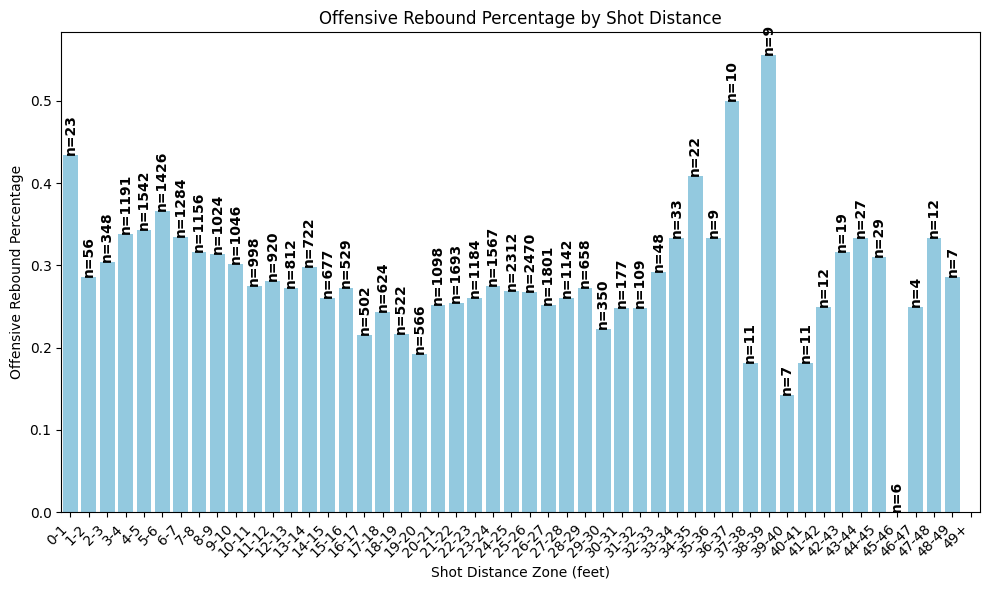

In [21]:
# Categorize each shot into the corresponding zones based on shot distance

# Define the shot distance bins cut by 2 feet
shot_distance_bins = [x for x in range(0, 51, 1)]

# Update the zone_labels accordingly
zone_labels = [f'{dist}-{dist+1}' for dist in shot_distance_bins[:-1]]
zone_labels[-1] = f'{shot_distance_bins[-2]}+'
shot_distance['shot_distance_zone'] = pd.cut(shot_distance['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shot_distance.groupby('shot_distance_zone')['oreb'].mean()
sample_size_by_zone = shot_distance['shot_distance_zone'].value_counts().reindex(zone_labels, fill_value=0)

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# Add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone.iloc[index]}', ha='center', va='bottom', fontweight='bold', rotation='vertical')

plt.tight_layout()
plt.show()


There is a distinct difference between shots from 0-1 feet and 1-2 feet even with significant sample sizes:

- Proposed zones: 0-7, 7-11, 11-17, 17-21, 21-26, 26-30, 30+ 

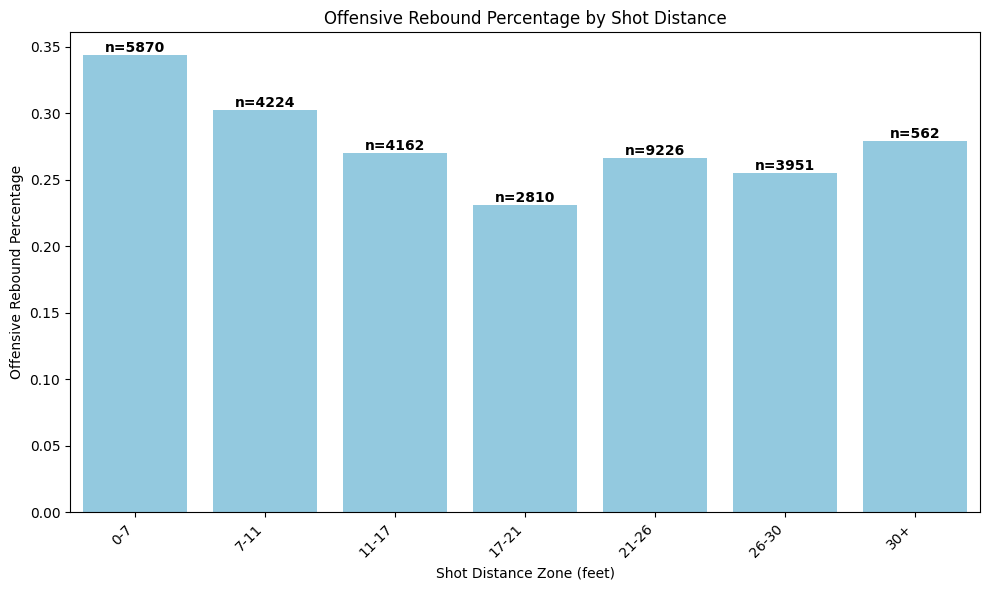

In [22]:
# Categorize each shot into the corresponding zones based on shot distance

# Define the shot distance bins
shot_distance_bins = [0, 7, 11, 17, 21, 26, 30, np.inf]

# Define the zone labels accordingly
zone_labels = ['0-7', '7-11', '11-17', '17-21', '21-26', '26-30', '30+']

shot_distance['shot_distance_zone'] = pd.cut(shot_distance['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage and sample size for each shot distance zone
oreb_by_zone = shot_distance.groupby('shot_distance_zone')['oreb'].mean()
sample_size_by_zone = shot_distance['shot_distance_zone'].value_counts()

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')

# Add sample size annotations to the bars
for index, value in enumerate(oreb_by_zone.values):
    plt.text(index, value, f'n={sample_size_by_zone[oreb_by_zone.index[index]]}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [23]:
shooter_data_train.head(2)

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0


In [24]:
shot_distance_bins

[0, 7, 11, 17, 21, 26, 30, inf]

In [25]:
zone_labels

['0-7', '7-11', '11-17', '17-21', '21-26', '26-30', '30+']

In [26]:
# Categorize "def_distance" column into corresponding zones
shooter_data_train['shot_distance_zone'] = pd.cut(shooter_data_train['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels)
shooter_data_test['shot_distance_zone'] = pd.cut(shooter_data_test['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels)


# Perform One-Hot Encoding for the "def_distance_zone" column
df_encoded_train = pd.get_dummies(shooter_data_train, columns=['shot_distance_zone'])
df_encoded_test = pd.get_dummies(shooter_data_test, columns=['shot_distance_zone'])

Shots from right near the hoop have the highest rebounding percentage with long threes being the next closest group. Mid-range shots are apparently inefficient for yet another reason.

#### Feature Engineering Average Distance of Defenders from the basket, each distance from the basket
- This feature will inform the spacing of the court at the time of the shot
- The further out the defense is, the harder it will be to box out and the more lanes there will be for offensive players to crash the boards
- There is even more risk here that a player will be on the other side of the court
    - The ground truth shooting hoop will be considered what hoop the shooter is closer to in order to maintain consistency despite the uncertainty

In [27]:
def calculate_def_distance_from_hoop(row):
    # Define the coordinates of the hoop
    hoop_coordinates = np.array([[4.0, 25.0], [90.0, 25.0]])  # Ensure the elements are floats
    def_coordinates = np.array([row['court_x'], row['court_y']])
    
    # Calculate the distance
    distance = np.linalg.norm(def_coordinates - hoop_coordinates[int(row['which_hoop'])])
    return distance

In [28]:
training_data = training_data.merge(shooter_data_train[['id', 'which_hoop']], left_on='id', right_on='id')
testing_data = testing_data.merge(shooter_data_test[['id', 'which_hoop']], left_on='id', right_on='id')

In [29]:
defenders_distance_train = training_data.loc[training_data.offense == 0]
defenders_distance_test = testing_data.loc[testing_data.offense == 0]

In [30]:
defenders_distance_train['def_distance'] = defenders_distance_train.apply(calculate_def_distance_from_hoop, axis=1)
defenders_distance_test['def_distance'] = defenders_distance_test.apply(calculate_def_distance_from_hoop, axis=1)

In [31]:
# Rank the defenders within each play (id) by distance from the hoop
defenders_distance_train['rank'] = defenders_distance_train.groupby('id')['def_distance'].rank(method='first')
defenders_distance_test['rank'] = defenders_distance_test.groupby('id')['def_distance'].rank(method='first')

# Pivot the DataFrame to get features for closest_def_to_hoop, second_closest_def_to_hoop, and so on
df_pivot = defenders_distance_train.pivot_table(index='id', columns='rank', values='def_distance').add_prefix('defender_').reset_index()
df_pivot_test = defenders_distance_test.pivot_table(index='id', columns='rank', values='def_distance').add_prefix('defender_').reset_index()

In [32]:
# Rename the columns to be more descriptive
df_pivot.columns = ['id'] + ['closest_def_to_hoop', 'second_closest_def_to_hoop', 'third_closest_def_to_hoop', 'fourth_closest_def_to_hoop', 'fifth_closest_def_to_hoop']
df_pivot_test.columns = ['id'] + ['closest_def_to_hoop', 'second_closest_def_to_hoop', 'third_closest_def_to_hoop', 'fourth_closest_def_to_hoop', 'fifth_closest_def_to_hoop']


# Optional: Fill missing values (if any) with a specific value, e.g., -1
df_pivot.fillna(-1, inplace=True)
df_pivot_test.fillna(-1, inplace=True)


In [33]:
def_mean_distances_train = defenders_distance_train.groupby('id')['def_distance'].transform('mean').iloc[::5]
def_mean_distances_test = defenders_distance_test.groupby('id')['def_distance'].transform('mean').iloc[::5]

In [34]:
def_mean_distances_train

0         15.978589
10        11.970084
20        17.251641
30        10.231322
40        18.507660
            ...    
308000    15.777790
308010    15.217020
308020    16.101837
308030    16.084247
308040    16.241978
Name: def_distance, Length: 30805, dtype: float64

In [35]:
df_encoded_train

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,shot_distance_zone_0-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21-26,shot_distance_zone_26-30,shot_distance_zone_30+
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,0,0,0,0,1,0,0
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,0,0,0,1,0,0,0
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,0,0,0,0,1,0,0
35,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,0,1,0,0,0,0,0
45,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308005,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,0,0,0,0,1,0,0
308015,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,0,0,0,0,0,0,1
308025,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,0,1,0,0,0,0,0
308035,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,0,0,0,0,0,1,0


In [36]:
# def distance and shot distance
df_encoded_train['mean_def_dist'] = def_mean_distances_train.values
df_encoded_test['mean_def_dist'] = def_mean_distances_test.values

#### Doing the same with offensive distances to the hoop

In [37]:
off_distance_train = training_data.loc[training_data.offense == 1]
off_distance_test = testing_data.loc[testing_data.offense == 1]

In [38]:
off_distance_train['off_distance'] = off_distance_train.apply(calculate_def_distance_from_hoop, axis=1)
off_distance_test['off_distance'] = off_distance_test.apply(calculate_def_distance_from_hoop, axis=1)

In [39]:
# Rank the defenders within each play (id) by distance from the hoop
off_distance_train['rank'] = off_distance_train.groupby('id')['off_distance'].rank(method='first')
off_distance_test['rank'] = off_distance_test.groupby('id')['off_distance'].rank(method='first')

# Pivot the DataFrame to get features for closest_def_to_hoop, second_closest_def_to_hoop, and so on
of_pivot = off_distance_train.pivot_table(index='id', columns='rank', values='off_distance').add_prefix('offense_').reset_index()
of_pivot_test = off_distance_test.pivot_table(index='id', columns='rank', values='off_distance').add_prefix('offense_').reset_index()

In [40]:
# Rename the columns to be more descriptive
of_pivot.columns = ['id'] + ['closest_off_to_hoop', 'second_closest_off_to_hoop', 'third_closest_off_to_hoop', 'fourth_closest_off_to_hoop', 'fifth_closest_off_to_hoop']
of_pivot_test.columns = ['id'] + ['closest_off_to_hoop', 'second_closest_off_to_hoop', 'third_closest_off_to_hoop', 'fourth_closest_off_to_hoop', 'fifth_closest_off_to_hoop']


# Optional: Fill missing values (if any) with a specific value, e.g., -1
of_pivot.fillna(-1, inplace=True)
of_pivot_test.fillna(-1, inplace=True)


In [41]:
off_mean_distances_train = off_distance_train.groupby('id')['off_distance'].transform('mean').iloc[::5]
off_mean_distances_test = off_distance_test.groupby('id')['off_distance'].transform('mean').iloc[::5]

In [42]:
off_mean_distances_train

5         20.537458
15        22.426203
25        22.744289
35        20.999461
45        24.600804
            ...    
308005    18.619553
308015    22.284880
308025    17.268374
308035    23.585862
308045    22.810152
Name: off_distance, Length: 30805, dtype: float64

In [43]:
pivot_train = df_pivot.merge(of_pivot, on='id')
pivot_test = df_pivot_test.merge(of_pivot_test, on='id')

In [44]:
df_encoded_train = df_encoded_train.merge(pivot_train, on='id')
df_encoded_test = df_encoded_test.merge(pivot_test, on='id')

In [45]:
df_encoded_train

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,shot_distance_zone_0-7,shot_distance_zone_7-11,...,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,0,0,...,7.633964,12.696228,18.308802,20.050756,21.203196,10.641781,11.430082,22.130707,24.810706,33.674014
1,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,0,0,...,6.951207,8.954561,13.582648,15.019406,15.342599,17.510933,20.646002,20.747640,25.787367,27.439075
2,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,0,0,...,7.585616,8.649579,17.621429,25.116109,27.285472,5.814472,21.457974,24.860005,27.413357,34.175635
3,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,0,1,...,6.140183,7.291817,8.300214,14.131598,15.292797,10.047281,22.132454,23.110874,24.290833,25.415862
4,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,0,0,...,12.897550,13.705211,20.071723,20.182427,25.681385,20.512189,21.590307,24.348532,26.562495,29.990495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,0,0,...,5.655688,17.025468,18.118633,18.357469,19.731694,8.830529,19.281527,20.708691,20.858928,23.418093
30801,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,0,0,...,7.200086,7.592854,15.012815,20.322350,25.956997,13.321681,20.627279,21.207575,25.102488,31.165373
30802,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,0,1,...,5.961899,11.343778,14.310515,14.553908,34.339084,8.023521,12.947685,15.704342,21.558116,28.108204
30803,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,0,0,...,12.243245,12.873617,13.942461,18.613618,22.748294,19.649618,21.416060,22.502382,24.697956,29.663295


In [46]:
df_encoded_test

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,shot_distance_zone_0-7,shot_distance_zone_7-11,...,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,1-1,24.245777,10.246514,s,1,1,25.051084,0.0,0,0,...,7.757562,11.218385,16.099277,16.760472,20.385939,9.109627,20.085814,20.206248,21.774790,25.051084
1,2-1,65.999802,18.595853,s,1,1,24.839940,1.0,0,0,...,6.340095,13.833010,15.261384,16.566201,26.275842,9.444025,23.705128,24.839940,24.955387,30.669825
2,2-5,13.972919,32.420723,s,1,1,12.430858,0.0,0,0,...,5.097449,8.944801,15.265664,17.441575,18.059707,9.351841,12.430858,12.826872,25.678268,27.513270
3,2-7,29.426405,25.673611,s,1,1,25.435326,0.0,0,0,...,9.615957,14.007248,15.799460,20.134035,22.562741,21.081537,22.565430,25.157609,25.435326,26.110857
4,3-2,24.571083,37.600301,s,1,1,24.123371,0.0,0,0,...,6.686981,6.741170,13.617039,14.226427,18.579304,5.440673,11.080636,24.123371,27.272304,32.468007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13197,5020-38,73.369204,6.589166,s,1,1,24.810122,1.0,0,0,...,6.520961,10.079780,18.344465,18.706980,20.703717,7.105817,24.810122,26.431405,26.976307,28.617305
13198,5020-44,10.383696,23.385000,s,1,1,6.584816,0.0,1,0,...,6.937739,9.127514,11.103072,11.678740,20.222079,6.584816,15.195071,17.108997,19.834889,28.614364
13199,5020-45,63.967513,21.630555,s,1,1,26.249639,1.0,0,0,...,4.446450,13.560970,16.782539,18.930329,20.671393,4.766418,9.815761,19.917706,22.997874,26.249639
13200,5020-50,86.769934,45.832432,s,1,1,21.081356,1.0,0,0,...,10.461076,11.505413,16.827591,21.575719,27.067468,18.444180,21.081356,26.369234,31.602478,38.394288


Trying out an XGBoost Model on the player coordinate engineered features

In [51]:
# Perform train-test split
X = df_encoded_train.drop(columns=['id', 'court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 'distance_from_hoop', 'which_hoop'], axis=1)
X_test = df_encoded_test.drop(columns=['id', 'court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 'distance_from_hoop', 'which_hoop'], axis=1)

In [52]:
# Create a StandardScaler object
scaler = StandardScaler()

# Extract the continuous features from the DataFrame
continuous_features = X.iloc[:, 7:]  # the continuous features start from the 10th column
continuous_features_test = X_test.iloc[:, 7:]

# Fit and transform the continuous features using the StandardScaler
scaled_continuous_features = scaler.fit_transform(continuous_features)
scaled_continuous_features_test = scaler.transform(continuous_features_test)

# Convert the scaled_continuous_features back to a DataFrame with the original column names
scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=continuous_features.columns)
scaled_continuous_df_test = pd.DataFrame(scaled_continuous_features_test, columns=continuous_features_test.columns)

# Concatenate the scaled continuous features with the categorical features (if any)
# Use the appropriate columns indices depending on your DataFrame structure
X = pd.concat([X.iloc[:, :7], scaled_continuous_df], axis=1)
X_test = pd.concat([X_test.iloc[:, :7], scaled_continuous_df_test], axis=1)

In [53]:
X

,shot_distance_zone_0-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21-26,shot_distance_zone_26-30,shot_distance_zone_30+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,0,0,0,0,1,0,0,0.786057,0.280024,0.707359,1.194021,0.876404,0.314668,0.394397,-0.562562,0.385818,0.156934,1.509469
1,0,0,0,1,0,0,0,-0.331162,0.090078,-0.208605,0.106853,-0.320979,-1.069568,1.759438,1.021993,0.090994,0.426478,-0.133723
2,0,0,0,0,1,0,0,1.140872,0.266573,-0.283265,1.035903,2.081879,1.751264,-0.564888,1.161601,0.967612,0.875227,1.641669
3,0,1,0,0,0,0,0,-0.815777,-0.135552,-0.615646,-1.108279,-0.532263,-1.081331,0.276258,1.277569,0.594756,0.013457,-0.666933
4,0,0,0,0,1,0,0,1.490940,1.744373,0.954359,1.599550,0.907740,1.372389,2.355850,1.184354,0.858583,0.640402,0.538693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,0,0,0,0,1,0,0,0.730092,-0.270340,1.767161,1.150276,0.473428,-0.032891,0.034464,0.787390,0.082692,-0.933698,-1.193436
30801,0,0,0,0,0,0,1,0.573799,0.159317,-0.541952,0.435837,0.941039,1.437487,0.926948,1.018774,0.189037,0.237462,0.848327
30802,0,1,0,0,0,0,0,0.820408,-0.185151,0.376278,0.274286,-0.431760,3.417283,-0.125905,-0.301630,-0.984067,-0.740732,0.042623
30803,0,0,0,0,0,1,0,0.815505,1.562343,0.750784,0.189621,0.534388,0.679611,2.184439,1.154394,0.465046,0.125817,0.452461


In [54]:
y = train_pbp['is_oreb']  # Assuming train_pbp is the DataFrame containing the target variable 'is_oreb'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [474]:
pd.set_option('display.max_columns', None)

In [55]:
# Train the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss', max_depth=3, min_child_weight=5)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate log loss
log_loss_score = log_loss(y_test, y_pred_prob)
print("Log Loss:", log_loss_score)

Log Loss: 0.5824318550368374


In [337]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss', max_depth=3, min_child_weight=5)
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [281]:
df_encoded_test

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,def_distance_zone,shot_distance_zone_0-3,shot_distance_zone_3-7,...,shot_distance_zone_17-21,shot_distance_zone_21-26,shot_distance_zone_26-30,shot_distance_zone_30+,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop,mean_def_dist
0,1-1,24.245777,10.246514,s,1,1,0.0,21-26,0,0,...,0,1,0,0,9.109627,20.085814,20.206248,21.774790,25.051084,14.444327
1,2-1,65.999802,18.595853,s,1,1,1.0,21-26,0,0,...,0,1,0,0,9.444025,23.705128,24.839940,24.955387,30.669825,15.655307
2,2-5,13.972919,32.420723,s,1,1,0.0,11-17,0,0,...,0,0,0,0,9.351841,12.430858,12.826872,25.678268,27.513270,12.961839
3,2-7,29.426405,25.673611,s,1,1,0.0,21-26,0,0,...,0,1,0,0,21.081537,22.565430,25.157609,25.435326,26.110857,16.423888
4,3-2,24.571083,37.600301,s,1,1,0.0,21-26,0,0,...,0,1,0,0,5.440673,11.080636,24.123371,27.272304,32.468007,11.970184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13197,5020-38,73.369204,6.589166,s,1,1,1.0,21-26,0,0,...,0,1,0,0,7.105817,24.810122,26.431405,26.976307,28.617305,14.871180
13198,5020-44,10.383696,23.385000,s,1,1,0.0,3-7,0,1,...,0,0,0,0,6.584816,15.195071,17.108997,19.834889,28.614364,11.813829
13199,5020-45,63.967513,21.630555,s,1,1,1.0,26-30,0,0,...,0,0,1,0,4.766418,9.815761,19.917706,22.997874,26.249639,14.878336
13200,5020-50,86.769934,45.832432,s,1,1,1.0,21-26,0,0,...,0,1,0,0,18.444180,21.081356,26.369234,31.602478,38.394288,17.487453


In [338]:
X_test = df_encoded_test.drop(columns=['id', 'court_x', 'court_y', 'annotation_code', 'offense', 'shooter', 'distance_from_hoop', 'which_hoop'], axis=1)

In [339]:
y_test_pred = model.predict_proba(X_test)[:, 1]

In [343]:
len(y_test_pred)

13202

In [348]:
df_encoded_test['id']

0            1-1
1            2-1
2            2-5
3            2-7
4            3-2
          ...   
13197    5020-38
13198    5020-44
13199    5020-45
13200    5020-50
13201    5020-51
Name: id, Length: 13202, dtype: object

In [346]:
test_pbp.sort_values(by='id')

,id,team,opponent,conference,opp_conference
6737,1-1,Virginia Tech,Liberty,ACC,Atlantic Sun
2385,10-1,Duke,Army,ACC,Patriot League
4762,10-11,Duke,Army,ACC,Patriot League
8418,10-2,Duke,Army,ACC,Patriot League
6116,10-4,Duke,Army,ACC,Patriot League
...,...,...,...,...,...
4985,999-2,St. John's,DePaul,BigEast,BigEast
1069,999-6,St. John's,DePaul,BigEast,BigEast
10253,999-7,St. John's,DePaul,BigEast,BigEast
10357,999-8,DePaul,St. John's,BigEast,BigEast


In [350]:
submission = pd.DataFrame(df_encoded_test['id'])
submission['pred'] = y_test_pred
submission.to_csv('submission3.csv', index=False)

In [542]:
X

,shot_distance_zone_0-3,shot_distance_zone_3-7,shot_distance_zone_7-11,shot_distance_zone_11-17,shot_distance_zone_17-21,shot_distance_zone_21-26,shot_distance_zone_26-30,shot_distance_zone_30+,mean_def_dist,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,0,0,0,0,0,1,0,0,0.786057,0.280024,0.707359,1.194021,0.876404,0.314668,0.394397,-0.562562,0.385818,0.156934,1.509469
1,0,0,0,0,1,0,0,0,-0.331162,0.090078,-0.208605,0.106853,-0.320979,-1.069568,1.759438,1.021993,0.090994,0.426478,-0.133723
2,0,0,0,0,0,1,0,0,1.140872,0.266573,-0.283265,1.035903,2.081879,1.751264,-0.564888,1.161601,0.967612,0.875227,1.641669
3,0,0,1,0,0,0,0,0,-0.815777,-0.135552,-0.615646,-1.108279,-0.532263,-1.081331,0.276258,1.277569,0.594756,0.013457,-0.666933
4,0,0,0,0,0,1,0,0,1.490940,1.744373,0.954359,1.599550,0.907740,1.372389,2.355850,1.184354,0.858583,0.640402,0.538693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,0,0,0,0,0,1,0,0,0.730092,-0.270340,1.767161,1.150276,0.473428,-0.032891,0.034464,0.787390,0.082692,-0.933698,-1.193436
30801,0,0,0,0,0,0,0,1,0.573799,0.159317,-0.541952,0.435837,0.941039,1.437487,0.926948,1.018774,0.189037,0.237462,0.848327
30802,0,0,1,0,0,0,0,0,0.820408,-0.185151,0.376278,0.274286,-0.431760,3.417283,-0.125905,-0.301630,-0.984067,-0.740732,0.042623
30803,0,0,0,0,0,0,1,0,0.815505,1.562343,0.750784,0.189621,0.534388,0.679611,2.184439,1.154394,0.465046,0.125817,0.452461


In [ ]:
xgb_y_pred = y_pred_prob.copy()

In [541]:
model.feature_importances_

array([0.        , 0.06350619, 0.02777519, 0.05070916, 0.03075485,
       0.06699218, 0.06584641, 0.        , 0.05073701, 0.04325365,
       0.0390568 , 0.03689309, 0.0508565 , 0.04780873, 0.06865963,
       0.1910965 , 0.0816355 , 0.04716536, 0.03725328], dtype=float32)

#### Feature Engineering Measurement of Rebound Positioning

##### Assigning box out responsibilities

*Offensive Rebounding Player Assignment Algorithm*

This algorithm is designed to optimize the assignment of defensive players to their respective offensive players during a basketball game to enhance the team's chances of securing an defensive rebound.

Step 1: Creating a Spatial Graph

The algorithm starts by constructing a spatial graph that represents the relationships between offensive players and the hoop (basket). Each offensive player and the hoop are represented as nodes in the graph, and edges are added between offensive players based on their spatial proximity. This graph reflects the players' positioning on the court and helps identify the most strategic offensive players to box out.

Step 2: Betweenness Centrality

The algorithm then calculates a measure called "betweenness centrality" for each offensive player in the graph. This metric quantifies how often an offensive player lies on the shortest path between other offensive players and the hoop. High betweenness centrality indicates that a player is in a critical position on the court, and boxing out such players becomes crucial for effective rebounding. In basketball terms, offensive players with high betweenness centrality are in critical positions that can impact the overall offensive flow and create more scoring opportunities. Therefore, these players become important targets for defensive players to box out and prevent them from securing offensive rebounds.

Step 3: Optimizing Player Assignments

Next, the algorithm aims to optimize the assignment of defensive players to offensive players. To achieve this, it creates a cost matrix that considers both the distance between defensive and offensive players and the offensive players' betweenness centrality. The Hungarian algorithm is then employed to find the best possible player assignments that maximize the overall betweenness centrality while minimizing the distances.

Step 4: Iterative Refinement

To further improve the assignments, the algorithm iteratively updates the player assignments and optimizes the betweenness centrality and distances. This iterative refinement process enhances the quality of player matchups, ensuring that no defensive player is left without a specific offensive player to box out.

Step 5: Assigning Remaining Defenders

After the iterations, there may still be some defenders without an offensive player assigned to them. To address this, the algorithm finds the closest unassigned offensive player for each remaining defender based on the distances.

In [78]:
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def construct_graph(offensive_players, hoop, distances):
    graph = nx.Graph()
    for player1 in offensive_players:
        for player2 in offensive_players:
            if not np.array_equal(player1, player2):
                distance = calculate_distance(player1, player2)
                graph.add_edge(tuple(player1), tuple(player2), weight=1.0 / distance)
        
        distance_to_hoop = distances[(tuple(player1), tuple(hoop))]
        graph.add_edge(tuple(player1), tuple(hoop), weight=1.0 / distance_to_hoop)
    
    return graph

def calculate_betweenness_centralities(graph):
    return nx.betweenness_centrality(graph, weight='weight')

def calculate_cost_matrix(defenders_, offensive_players_, distances, betweenness_centralities):
    num_defenders = len(defenders_)
    num_offensive_players = len(offensive_players_)
    cost_matrix = np.zeros((num_defenders_, num_offensive_players))

    for i, defender in enumerate(defenders_):
        for j, offensive_player in enumerate(offensive_players_):
            distance_cost = distances[(tuple(defender), tuple(offensive_player))]
            betweenness_cost = -betweenness_centralities[tuple(offensive_player)]
            cost_matrix[i, j] = distance_cost + betweenness_cost

    return cost_matrix

def assign_offensive_players(defenders_, offensive_players_, hoop, num_iterations=5):
    distances = {}
    for defender in defenders_:
        for offensive_player in offensive_players_:
            distances[(tuple(defender), tuple(offensive_player))] = calculate_distance(defender, offensive_player)
        distances[(tuple(defender), tuple(hoop))] = calculate_distance(defender, hoop)

    for offensive_player in offensive_players_:
        distances[(tuple(offensive_player), tuple(hoop))] = calculate_distance(offensive_player, hoop)

    assignments = {}
    unassigned_defenders = list(defenders_)

    for _ in range(num_iterations):
        graph = construct_graph(offensive_players, hoop, distances)
        betweenness_centralities = calculate_betweenness_centralities(graph)

        cost_matrix = calculate_cost_matrix(defenders_, offensive_players, distances, betweenness_centralities)

        # Use Hungarian algorithm to find the optimal assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        for i, j in zip(row_ind, col_ind):
            defender = tuple(defenders_[i])
            offensive_player = tuple(offensive_players[j])
            assignments[defender] = offensive_player
            # Update the set of unassigned defenders
            if any(np.array_equal(defender, a) for a in unassigned_defenders):
                unassigned_defenders = [x for x in unassigned_defenders if not (x == defender).all()]

    # Assign remaining defenders to offensive players based on distance
    for defender in unassigned_defenders:
        min_distance = float('inf')
        closest_offensive_player = None
        for offensive_player in offensive_players:
            distance = distances[(tuple(defender), tuple(offensive_player))]
            if distance < min_distance:
                min_distance = distance
                closest_offensive_player = tuple(offensive_player)
        assignments[tuple(defender)] = closest_offensive_player

    return assignments

# Example usage:
defenders = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4]])
offensive_players = np.array([[5, 0], [6, 1], [7, 2], [8, 3], [9, 4]])
hoop = np.array([10, 5])

assignments = assign_offensive_players(defenders, offensive_players, hoop)
print(assignments)

TypeError: 'dict' object is not callable

In [77]:
defenders_

array([[13.54348179, 11.22192419],
       [21.02220154, 13.78255166],
       [19.34343826, 20.12500029],
       [14.48016746, 20.9977205 ],
       [10.90546892, 28.53472233]])

In [58]:
copy_training_data = training_data.copy()
copy_testing_data = testing_data.copy()

In [59]:
copy_training_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop
0,2-2,72.807686,37.409669,d1,0,0,1.0
1,2-2,79.080643,31.477796,d2,0,0,1.0
2,2-2,69.956321,24.467300,d3,0,0,1.0
3,2-2,75.468933,13.861763,d4,0,0,1.0
4,2-2,84.973496,19.254422,d5,0,0,1.0
...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,1,1,1.0
308046,5020-52,86.958520,4.382292,t1,1,0,1.0
308047,5020-52,58.962087,26.764930,t2,1,0,1.0
308048,5020-52,76.777949,20.427222,t3,1,0,1.0


In [ ]:
# Group the data by Rebound ID
grouped_data = copy_training_data.groupby('id')

# Loop through each rebound's data and assign players
assignments_list = []
list_of_ids = []
for id, group in grouped_data:
    defenders = group[group['offense'] == 0][['court_x', 'court_y']].values
    offensive_players = group[group['offense'] == 1][['court_x', 'court_y']].values
    hoop = [4, 25] if group['which_hoop'].iloc[0] == 0 else [90, 25]
    
    assignments = assign_offensive_players(defenders, offensive_players, hoop)
    list_of_ids.append(id)
    assignments_list.append(assignments)

In [107]:
assignments_dict = {}
i = 0
for list in assignments_list:
    id = list_of_ids[i]
    assignments_dict[id] = list
    i += 1

In [62]:
def_training_data = copy_training_data.loc[copy_training_data.offense == 0]

# Map the assignments to the DataFrame and create a new column
off_coords = def_training_data.apply(lambda row: assignments_dict[row['id']][(row['court_x'], row['court_y'])], axis=1)
# Assigning offensive players
def_training_data[['off_x', 'off_y']] = off_coords.apply(pd.Series)

# The data DataFrame now contains the assigned_annotation_code column with the matched players for each rebound's data points.
def_training_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,off_x,off_y
0,2-2,72.807686,37.409669,d1,0,0,1.0,69.994331,39.674616
1,2-2,79.080643,31.477796,d2,0,0,1.0,82.692421,32.736070
2,2-2,69.956321,24.467300,d3,0,0,1.0,58.550842,12.962986
3,2-2,75.468933,13.861763,d4,0,0,1.0,71.667114,12.603488
4,2-2,84.973496,19.254422,d5,0,0,1.0,81.741959,17.097372
...,...,...,...,...,...,...,...,...,...
308040,5020-52,73.893471,11.121111,d1,0,0,1.0,70.669644,7.270347
308041,5020-52,82.631800,7.270347,d2,0,0,1.0,86.958520,4.382292
308042,5020-52,68.633583,23.555972,d3,0,0,1.0,58.962087,26.764930
308043,5020-52,81.613738,21.389860,d4,0,0,1.0,76.777949,20.427222


In [75]:
# Group the data by Rebound ID
grouped_data = copy_testing_data.groupby('id')

# Loop through each rebound's data and assign players
assignments_list = []
list_of_ids = []
for id, group in grouped_data:
    defenders_test = group[group['offense'] == 0][['court_x', 'court_y']].values
    offensive_players_test = group[group['offense'] == 1][['court_x', 'court_y']].values
    hoop_test = [4, 25] if group['which_hoop'].iloc[0] == 0 else [90, 25]
    
    assignments = assign_offensive_players(defenders_test, offensive_players_test, hoop_test)
    list_of_ids.append(id)
    assignments_list.append(assignments)

TypeError: 'dict' object is not callable

In [ ]:
assignments_dict = {}
i = 0
for list in assignments_list:
    id = list_of_ids[i]
    assignments_dict[id] = list
    i += 1

In [ ]:
def_testing_data = copy_testing_data.loc[copy_testing_data.offense == 0]

# Map the assignments to the DataFrame and create a new column
off_coords = def_testing_data.apply(lambda row: assignments_dict[row['id']][(row['court_x'], row['court_y'])], axis=1)
# Assigning offensive players
def_testing_data[['off_x', 'off_y']] = off_coords.apply(pd.Series)

# The data DataFrame now contains the assigned_annotation_code column with the matched players for each rebound's data points.
def_testing_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,off_x,off_y
0,2-2,72.807686,37.409669,d1,0,0,1.0,69.994331,39.674616
1,2-2,79.080643,31.477796,d2,0,0,1.0,82.692421,32.736070
2,2-2,69.956321,24.467300,d3,0,0,1.0,58.550842,12.962986
3,2-2,75.468933,13.861763,d4,0,0,1.0,71.667114,12.603488
4,2-2,84.973496,19.254422,d5,0,0,1.0,81.741959,17.097372
...,...,...,...,...,...,...,...,...,...
308040,5020-52,73.893471,11.121111,d1,0,0,1.0,70.669644,7.270347
308041,5020-52,82.631800,7.270347,d2,0,0,1.0,86.958520,4.382292
308042,5020-52,68.633583,23.555972,d3,0,0,1.0,58.962087,26.764930
308043,5020-52,81.613738,21.389860,d4,0,0,1.0,76.777949,20.427222


Visualizing example plays and the assigned box out responsibilities for each offensive player

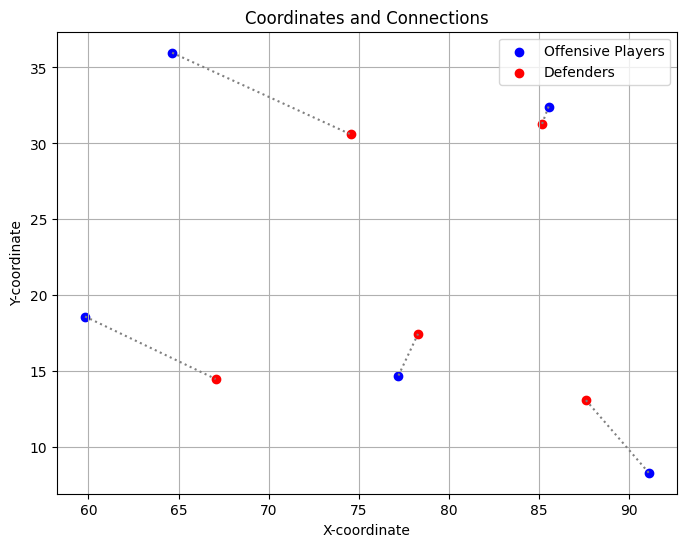

In [79]:
df = pd.DataFrame(def_training_data[35:40])

# Plotting the coordinates and connecting the pairs of players with lines
plt.figure(figsize=(8, 6))
plt.scatter(df['off_x'], df['off_y'], color='blue', label='Offensive Players')
plt.scatter(df['court_x'], df['court_y'], color='red', label='Defenders')

# Connect the pairs of players with lines
for i, row in df.iterrows():
    plt.plot([row['off_x'], row['court_x']], [row['off_y'], row['court_y']], color='gray', linestyle='dotted')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Coordinates and Connections')
plt.legend()
plt.grid(True)
plt.show()


##### Now that we know which offensive player each defensive player is responsible for boxing out, there are a host of new ways to develop features based on angles (between pairs of players and the hoop) and distances (from hoop to player and player to player)

Creating features for angles between each pair of players, distances between the pairs, and offensive player's distance to the basket

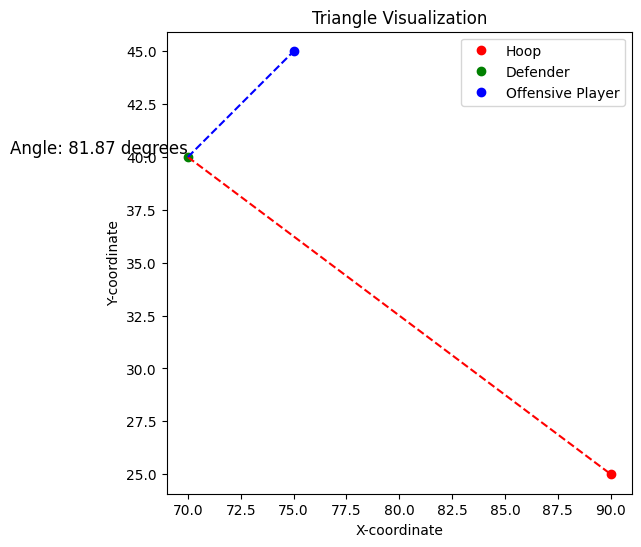

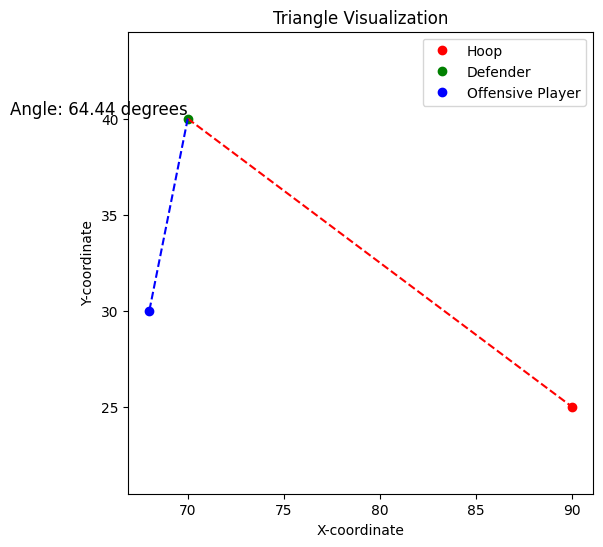

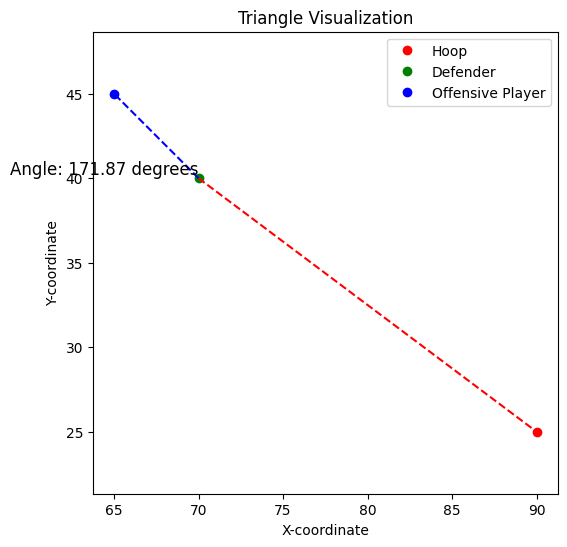

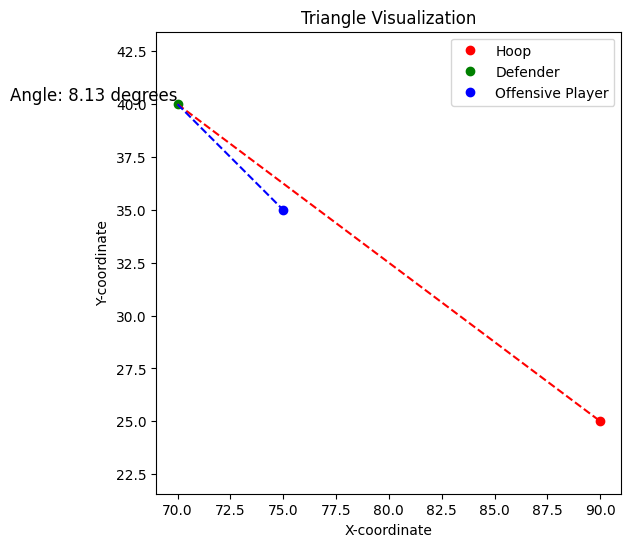

In [521]:
def calculate_angle(hoop, defender, offensive_player):
    # Calculate vectors from defender to hoop and defender to offensive player
    vector_hoop = [hoop[0] - defender[0], hoop[1] - defender[1]]
    vector_offensive = [offensive_player[0] - defender[0], offensive_player[1] - defender[1]]
    
    # Calculate the dot product of the two vectors
    dot_product = vector_hoop[0] * vector_offensive[0] + vector_hoop[1] * vector_offensive[1]
    
    # Calculate the magnitudes of the vectors
    magnitude_hoop = math.sqrt(vector_hoop[0] ** 2 + vector_hoop[1] ** 2)
    magnitude_offensive = math.sqrt(vector_offensive[0] ** 2 + vector_offensive[1] ** 2)
    
    # Calculate the angle between the vectors using the dot product formula
    angle_radians = math.acos(dot_product / (magnitude_hoop * magnitude_offensive))
    
    # Convert the angle to degrees
    angle_degrees = math.degrees(angle_radians)
    
    return angle_degrees

def plot_triangle(hoop, defender, offensive_player, angle):
    plt.figure(figsize=(6, 6))
    
    # Plot hoop, defender, and offensive player
    plt.plot(hoop[0], hoop[1], 'ro', label='Hoop')
    plt.plot(defender[0], defender[1], 'go', label='Defender')
    plt.plot(offensive_player[0], offensive_player[1], 'bo', label='Offensive Player')

    # Connect lines to form the triangle
    plt.plot([defender[0], hoop[0]], [defender[1], hoop[1]], 'r--')
    plt.plot([defender[0], offensive_player[0]], [defender[1], offensive_player[1]], 'b--')

    # Add angle text
    angle_text = f'Angle: {angle:.2f} degrees'
    plt.text(defender[0], defender[1], angle_text, ha='right', va='bottom', fontsize=12)

    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.legend()
    plt.title('Triangle Visualization')
    plt.axis('equal')
    plt.show()
    
# Example 1: Offensive player in front of the defender (good position for a rebound)
hoop = (90, 25)
defender = (70, 40)
offensive_player = (75, 45)
angle = calculate_angle(hoop, defender, offensive_player)
plot_triangle(hoop, defender, offensive_player, angle)

# Example 2: Offensive player behind the defender (good position for the offensive player)
hoop = (90, 25)
defender = (70, 40)
offensive_player = (68, 30)
angle = calculate_angle(hoop, defender, offensive_player)
plot_triangle(hoop, defender, offensive_player, angle)

# Example 3: Offensive player to the left of the defender
hoop = (90, 25)
defender = (70, 40)
offensive_player = (65, 45)
angle = calculate_angle(hoop, defender, offensive_player)
plot_triangle(hoop, defender, offensive_player, angle)

# Example 4: Offensive player to the right of the defender
hoop = (90, 25)
defender = (70, 40)
offensive_player = (75, 35)
angle = calculate_angle(hoop, defender, offensive_player)
plot_triangle(hoop, defender, offensive_player, angle)


In [80]:
def_training_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop,off_x,off_y
0,2-2,72.807686,37.409669,d1,0,0,1.0,69.994331,39.674616
1,2-2,79.080643,31.477796,d2,0,0,1.0,82.692421,32.736070
2,2-2,69.956321,24.467300,d3,0,0,1.0,58.550842,12.962986
3,2-2,75.468933,13.861763,d4,0,0,1.0,71.667114,12.603488
4,2-2,84.973496,19.254422,d5,0,0,1.0,81.741959,17.097372
...,...,...,...,...,...,...,...,...,...
308040,5020-52,73.893471,11.121111,d1,0,0,1.0,70.669644,7.270347
308041,5020-52,82.631800,7.270347,d2,0,0,1.0,86.958520,4.382292
308042,5020-52,68.633583,23.555972,d3,0,0,1.0,58.962087,26.764930
308043,5020-52,81.613738,21.389860,d4,0,0,1.0,76.777949,20.427222


In [81]:
def calculate_distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

def calculate_new_features(hoop, defender, offensive):
    def vector_angle(v1, v2):
        dot_product = v1[0]*v2[0] + v1[1]*v2[1]
        magnitude_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
        magnitude_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
        return math.degrees(math.acos(dot_product / (magnitude_v1 * magnitude_v2)))

    hoop_x, hoop_y = hoop[0], hoop[1]
    def_x, def_y = defender[0], defender[1]
    off_x, off_y = offensive[0], offensive[1]

    # Calculate distances between players and the hoop
    distance_def_hoop = calculate_distance((hoop_x, hoop_y), (def_x, def_y))
    distance_off_hoop = calculate_distance((hoop_x, hoop_y), (off_x, off_y))

    # Calculate distances between players
    distance_def_off = calculate_distance((def_x, def_y), (off_x, off_y))

    # Calculate angles between players and the hoop
    angle_def_hoop_off = vector_angle((hoop_x - def_x, hoop_y - def_y), (off_x - def_x, off_y - def_y))
    angle_off_hoop_def = vector_angle((def_x - off_x, def_y - off_y), (hoop_x - off_x, hoop_y - off_y))

    # Calculate angle where defender is the vertex
    angle_defender_vertex = 180 - angle_def_hoop_off - angle_off_hoop_def

    return pd.Series([distance_def_hoop, distance_off_hoop, distance_def_off, angle_defender_vertex])


In [82]:
def_training_data['hoop_x'] = def_training_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
def_training_data['hoop_y'] = 25
def_training_data.rename(columns={'court_x': 'def_x', 'court_y': 'def_y'}, inplace=True)

In [36]:
def_testing_data['hoop_x'] = def_testing_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
def_testing_data['hoop_y'] = 25
def_testing_data.rename(columns={'court_x': 'def_x', 'court_y': 'def_y'}, inplace=True)

In [83]:
def apply_calculate_new_features(row):
    return calculate_new_features((row['hoop_x'], row['hoop_y']), (row['def_x'], row['def_y']), (row['off_x'], row['off_y']))

In [86]:
new_feats = def_training_data.apply(apply_calculate_new_features, axis=1)
# new_feats_test = def_testing_data.apply(apply_calculate_new_features, axis=1)

In [87]:
def_training_data[['distance_def_hoop', 'distance_off_hoop', 'distance_def_off', 'angle_defender_vertex']] = new_feats
# def_testing_data[['distance_def_hoop', 'distance_off_hoop', 'distance_def_off', 'angle_defender_vertex']] = new_feats_test

Making columns for each player on the court to represent their relation to the hoop and their paired player

In [88]:
# Create an empty list to store the stacked data
stacked_data = []

# Group the data by 'id' column
grouped = def_training_data.groupby('id')

# Iterate through each group (defender) and stack the columns
for group_name, group_data in grouped:
    for defender_num in range(1, len(group_data) + 1):
        defender_data = group_data.iloc[defender_num - 1]
        stacked_data.append([group_name, defender_num, defender_data['distance_def_hoop'], defender_data['distance_off_hoop'],
                             defender_data['distance_def_off'], defender_data['angle_defender_vertex']])

# Create a new DataFrame from the stacked data
df_pivot = pd.DataFrame(stacked_data, columns=['id', 'defender_num', 'distance_def_hoop', 'distance_off_hoop',
                                               'distance_def_off', 'angle_defender_vertex'])

In [41]:
# Create an empty list to store the stacked data
stacked_data = []

# Group the data by 'id' column
grouped = def_testing_data.groupby('id')

# Iterate through each group (defender) and stack the columns
for group_name, group_data in grouped:
    for defender_num in range(1, len(group_data) + 1):
        defender_data = group_data.iloc[defender_num - 1]
        stacked_data.append([group_name, defender_num, defender_data['distance_def_hoop'], defender_data['distance_off_hoop'],
                             defender_data['distance_def_off'], defender_data['angle_defender_vertex']])

# Create a new DataFrame from the stacked data
df_pivot_test = pd.DataFrame(stacked_data, columns=['id', 'defender_num', 'distance_def_hoop', 'distance_off_hoop',
                                               'distance_def_off', 'angle_defender_vertex'])

In [89]:
df_encoded_train

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,shot_distance_zone_0-7,shot_distance_zone_7-11,...,closest_def_to_hoop,second_closest_def_to_hoop,third_closest_def_to_hoop,fourth_closest_def_to_hoop,fifth_closest_def_to_hoop,closest_off_to_hoop,second_closest_off_to_hoop,third_closest_off_to_hoop,fourth_closest_off_to_hoop,fifth_closest_off_to_hoop
0,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,0,0,...,7.633964,12.696228,18.308802,20.050756,21.203196,10.641781,11.430082,22.130707,24.810706,33.674014
1,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,0,0,...,6.951207,8.954561,13.582648,15.019406,15.342599,17.510933,20.646002,20.747640,25.787367,27.439075
2,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,0,0,...,7.585616,8.649579,17.621429,25.116109,27.285472,5.814472,21.457974,24.860005,27.413357,34.175635
3,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,0,1,...,6.140183,7.291817,8.300214,14.131598,15.292797,10.047281,22.132454,23.110874,24.290833,25.415862
4,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,0,0,...,12.897550,13.705211,20.071723,20.182427,25.681385,20.512189,21.590307,24.348532,26.562495,29.990495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,0,0,...,5.655688,17.025468,18.118633,18.357469,19.731694,8.830529,19.281527,20.708691,20.858928,23.418093
30801,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,0,0,...,7.200086,7.592854,15.012815,20.322350,25.956997,13.321681,20.627279,21.207575,25.102488,31.165373
30802,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,0,1,...,5.961899,11.343778,14.310515,14.553908,34.339084,8.023521,12.947685,15.704342,21.558116,28.108204
30803,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,0,0,...,12.243245,12.873617,13.942461,18.613618,22.748294,19.649618,21.416060,22.502382,24.697956,29.663295


In [90]:
# Pivot the DataFrame to have defender_num as columns
df_pivot_stacked = df_pivot.pivot_table(index='id', columns='defender_num', values=['distance_def_hoop', 'distance_off_hoop', 'distance_def_off', 'angle_defender_vertex'])

# Flatten the MultiIndex column names
df_pivot_stacked.columns = [f"{col[0]}_{col[1]}" for col in df_pivot_stacked.columns]

# Reset the index to make 'id' a regular column
df_pivot_stacked.reset_index(inplace=True)

In [43]:
# Pivot the DataFrame to have defender_num as columns
df_pivot_stacked_test = df_pivot_test.pivot_table(index='id', columns='defender_num', values=['distance_def_hoop', 'distance_off_hoop', 'distance_def_off', 'angle_defender_vertex'])

# Flatten the MultiIndex column names
df_pivot_stacked_test.columns = [f"{col[0]}_{col[1]}" for col in df_pivot_stacked_test.columns]

# Reset the index to make 'id' a regular column
df_pivot_stacked_test.reset_index(inplace=True)

In [91]:
# Assuming df_pivot_stacked contains the stacked DataFrame

# Normalize the data using StandardScaler
pivot_scaler = StandardScaler()
normalized_data = pivot_scaler.fit_transform(df_pivot_stacked.iloc[:, 1:])
# normalized_data_test = pivot_scaler.transform(df_pivot_stacked_test.iloc[:, 1:])

# Convert the normalized numpy array back to a DataFrame with column names
normalized_df = pd.DataFrame(normalized_data, columns=df_pivot_stacked.columns[1:])
# Convert the normalized numpy array back to a DataFrame with column names
# normalized_df_test = pd.DataFrame(normalized_data_test, columns=df_pivot_stacked_test.columns[1:])

# Combine the id column with the normalized DataFrame
normalized_df.insert(0, 'id', df_pivot_stacked['id'])
# Combine the id column with the normalized DataFrame
# normalized_df_test.insert(0, 'id', df_pivot_stacked['id'])

In [93]:
normalized_df

,id,angle_defender_vertex_1,angle_defender_vertex_2,angle_defender_vertex_3,angle_defender_vertex_4,angle_defender_vertex_5,distance_def_hoop_1,distance_def_hoop_2,distance_def_hoop_3,distance_def_hoop_4,...,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_off_hoop_1,distance_off_hoop_2,distance_off_hoop_3,distance_off_hoop_4,distance_off_hoop_5
0,10-10,-0.502295,-0.192301,-0.450499,-0.429588,-0.876574,-0.125753,0.541000,-0.380263,-0.573869,...,-0.795631,0.537281,1.475250,-1.477043,-0.240833,-0.296532,0.850424,0.889653,-1.151057,0.191390
1,10-12,0.868365,0.169097,0.051354,-0.917985,-0.728539,-1.368283,-1.535750,-0.257683,0.476611,...,-0.877186,1.388419,0.558434,-0.290032,-0.157048,-1.562042,-0.029140,0.281702,0.423784,0.489922
2,10-13,0.058509,-0.208939,0.818047,-0.098631,0.543434,1.306998,0.200276,-0.020640,-1.174178,...,0.190689,0.223065,0.471741,-1.104495,0.777796,0.883279,0.439212,-0.076378,-1.316799,0.194769
3,10-3,-0.653849,-0.473432,-0.040433,1.542525,0.238705,1.179739,-0.285635,0.821374,-1.162104,...,-0.749184,-0.910678,0.454316,-0.629572,0.117639,0.796640,-0.531712,0.849295,-1.439940,0.039646
4,10-6,0.740969,-0.538766,0.558689,0.572681,1.818297,0.567005,2.757116,-0.099729,-0.184240,...,2.436722,-0.295767,0.898067,1.247757,0.841177,1.271482,0.815388,0.373433,0.528993,-0.648697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,998-6,-0.113232,-0.638609,-0.653995,-0.516784,-0.452154,-1.263812,0.583296,-1.118012,-0.379825,...,-0.697373,0.365106,-0.870241,0.724923,0.236668,-1.178633,0.923014,-1.044240,0.391211,0.964660
30801,999-1,-0.229593,-0.837490,0.363313,-0.248014,-0.614343,0.613885,1.117305,-0.551441,-0.983465,...,0.185723,0.012098,0.925395,0.099463,0.405563,0.657977,1.124807,0.261013,-0.428995,0.855229
30802,999-3,2.058877,1.994608,-0.567191,-0.358587,0.103144,-0.797524,-1.038543,0.484968,0.523302,...,0.615302,-0.411484,0.502772,1.068563,0.548824,-0.845764,-1.608527,0.892444,1.184014,0.262627
30803,999-4,-0.269378,-0.072232,0.105381,-0.913545,1.374382,-1.468330,-0.972136,1.021691,1.343403,...,-0.636193,-0.027033,0.753726,0.019838,1.109745,-1.297993,-0.498322,1.059154,1.227361,0.213720


In [97]:
final = normalized_df.merge(train_pbp[['id', 'is_oreb']], on='id')

In [98]:
final

,id,angle_defender_vertex_1,angle_defender_vertex_2,angle_defender_vertex_3,angle_defender_vertex_4,angle_defender_vertex_5,distance_def_hoop_1,distance_def_hoop_2,distance_def_hoop_3,distance_def_hoop_4,...,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_off_hoop_1,distance_off_hoop_2,distance_off_hoop_3,distance_off_hoop_4,distance_off_hoop_5,is_oreb
0,10-10,-0.502295,-0.192301,-0.450499,-0.429588,-0.876574,-0.125753,0.541000,-0.380263,-0.573869,...,0.537281,1.475250,-1.477043,-0.240833,-0.296532,0.850424,0.889653,-1.151057,0.191390,0
1,10-12,0.868365,0.169097,0.051354,-0.917985,-0.728539,-1.368283,-1.535750,-0.257683,0.476611,...,1.388419,0.558434,-0.290032,-0.157048,-1.562042,-0.029140,0.281702,0.423784,0.489922,0
2,10-13,0.058509,-0.208939,0.818047,-0.098631,0.543434,1.306998,0.200276,-0.020640,-1.174178,...,0.223065,0.471741,-1.104495,0.777796,0.883279,0.439212,-0.076378,-1.316799,0.194769,0
3,10-3,-0.653849,-0.473432,-0.040433,1.542525,0.238705,1.179739,-0.285635,0.821374,-1.162104,...,-0.910678,0.454316,-0.629572,0.117639,0.796640,-0.531712,0.849295,-1.439940,0.039646,0
4,10-6,0.740969,-0.538766,0.558689,0.572681,1.818297,0.567005,2.757116,-0.099729,-0.184240,...,-0.295767,0.898067,1.247757,0.841177,1.271482,0.815388,0.373433,0.528993,-0.648697,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,998-6,-0.113232,-0.638609,-0.653995,-0.516784,-0.452154,-1.263812,0.583296,-1.118012,-0.379825,...,0.365106,-0.870241,0.724923,0.236668,-1.178633,0.923014,-1.044240,0.391211,0.964660,0
30801,999-1,-0.229593,-0.837490,0.363313,-0.248014,-0.614343,0.613885,1.117305,-0.551441,-0.983465,...,0.012098,0.925395,0.099463,0.405563,0.657977,1.124807,0.261013,-0.428995,0.855229,0
30802,999-3,2.058877,1.994608,-0.567191,-0.358587,0.103144,-0.797524,-1.038543,0.484968,0.523302,...,-0.411484,0.502772,1.068563,0.548824,-0.845764,-1.608527,0.892444,1.184014,0.262627,0
30803,999-4,-0.269378,-0.072232,0.105381,-0.913545,1.374382,-1.468330,-0.972136,1.021691,1.343403,...,-0.027033,0.753726,0.019838,1.109745,-1.297993,-0.498322,1.059154,1.227361,0.213720,0


In [ ]:
# def distance and shot distance

Trying out an XGBoost Model on the player coordinate engineered features

In [103]:
# Perform train-test split
X = final.drop(columns=['is_oreb', 'id'])
y = final['is_oreb']  # Assuming train_pbp is the DataFrame containing the target variable 'is_oreb'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [104]:
X

,angle_defender_vertex_1,angle_defender_vertex_2,angle_defender_vertex_3,angle_defender_vertex_4,angle_defender_vertex_5,distance_def_hoop_1,distance_def_hoop_2,distance_def_hoop_3,distance_def_hoop_4,distance_def_hoop_5,distance_def_off_1,distance_def_off_2,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_off_hoop_1,distance_off_hoop_2,distance_off_hoop_3,distance_off_hoop_4,distance_off_hoop_5
0,-0.502295,-0.192301,-0.450499,-0.429588,-0.876574,-0.125753,0.541000,-0.380263,-0.573869,0.098653,-0.795631,0.537281,1.475250,-1.477043,-0.240833,-0.296532,0.850424,0.889653,-1.151057,0.191390
1,0.868365,0.169097,0.051354,-0.917985,-0.728539,-1.368283,-1.535750,-0.257683,0.476611,0.398536,-0.877186,1.388419,0.558434,-0.290032,-0.157048,-1.562042,-0.029140,0.281702,0.423784,0.489922
2,0.058509,-0.208939,0.818047,-0.098631,0.543434,1.306998,0.200276,-0.020640,-1.174178,-0.293143,0.190689,0.223065,0.471741,-1.104495,0.777796,0.883279,0.439212,-0.076378,-1.316799,0.194769
3,-0.653849,-0.473432,-0.040433,1.542525,0.238705,1.179739,-0.285635,0.821374,-1.162104,-0.041193,-0.749184,-0.910678,0.454316,-0.629572,0.117639,0.796640,-0.531712,0.849295,-1.439940,0.039646
4,0.740969,-0.538766,0.558689,0.572681,1.818297,0.567005,2.757116,-0.099729,-0.184240,-1.103374,2.436722,-0.295767,0.898067,1.247757,0.841177,1.271482,0.815388,0.373433,0.528993,-0.648697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,-0.113232,-0.638609,-0.653995,-0.516784,-0.452154,-1.263812,0.583296,-1.118012,-0.379825,0.731085,-0.697373,0.365106,-0.870241,0.724923,0.236668,-1.178633,0.923014,-1.044240,0.391211,0.964660
30801,-0.229593,-0.837490,0.363313,-0.248014,-0.614343,0.613885,1.117305,-0.551441,-0.983465,0.432955,0.185723,0.012098,0.925395,0.099463,0.405563,0.657977,1.124807,0.261013,-0.428995,0.855229
30802,2.058877,1.994608,-0.567191,-0.358587,0.103144,-0.797524,-1.038543,0.484968,0.523302,-0.200097,0.615302,-0.411484,0.502772,1.068563,0.548824,-0.845764,-1.608527,0.892444,1.184014,0.262627
30803,-0.269378,-0.072232,0.105381,-0.913545,1.374382,-1.468330,-0.972136,1.021691,1.343403,1.443822,-0.636193,-0.027033,0.753726,0.019838,1.109745,-1.297993,-0.498322,1.059154,1.227361,0.213720


In [585]:
normalized_df

,angle_defender_vertex_1,angle_defender_vertex_2,angle_defender_vertex_3,angle_defender_vertex_4,angle_defender_vertex_5,distance_def_hoop_1,distance_def_hoop_2,distance_def_hoop_3,distance_def_hoop_4,distance_def_hoop_5,...,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_off_hoop_1,distance_off_hoop_2,distance_off_hoop_3,distance_off_hoop_4,distance_off_hoop_5,mean_def_dist,distance_from_hoop
0,-0.507281,-0.190575,-0.447978,-0.427008,-0.875265,-0.125753,0.541000,-0.380263,-0.573869,0.098653,...,1.480267,-1.464448,-0.231571,-0.304833,0.849623,0.890762,-1.142590,0.196883,-0.140019,0.901058
1,0.841641,0.171283,0.055200,-0.915704,-0.727249,-1.368283,-1.535750,-0.257683,0.476611,0.398536,...,0.563381,-0.280688,-0.148141,-1.571777,-0.030186,0.282859,0.428425,0.493668,-0.873384,0.057110
2,0.044629,-0.207234,0.823918,-0.095849,0.544560,1.306998,0.200276,-0.020640,-1.174178,-0.293143,...,0.476681,-1.092921,0.782739,0.876316,0.438296,-0.075193,-1.307929,0.200243,0.094578,0.513439
3,-0.656432,-0.335419,-0.036829,1.546313,0.239871,1.179739,-0.285635,0.821374,-1.162104,-0.041193,...,0.459255,-0.619299,0.125381,0.789578,-0.635957,0.850408,-1.430771,0.046027,0.236142,-0.805783
4,0.716265,-0.537480,0.563875,0.575875,1.819260,0.567005,2.757116,-0.099729,-0.184240,-1.103374,...,0.903040,1.252890,0.845850,1.264959,0.814577,0.374583,0.533378,-0.638286,0.743224,0.847624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30800,-0.124389,-0.637449,-0.652012,-0.514257,-0.450900,-1.263812,0.583296,-1.118012,-0.379825,0.731085,...,-0.865403,0.731488,0.243906,-1.187933,0.922233,-1.042979,0.395932,0.965628,-0.545115,0.740054
30801,-0.238904,-0.836583,0.367983,-0.245323,-0.613067,0.613885,1.117305,-0.551441,-0.983465,0.432955,...,0.930370,0.107740,0.412084,0.650758,1.124082,0.262172,-0.422282,0.856837,0.266828,1.635739
30802,2.013273,1.999113,-0.564978,-0.355963,0.104327,-0.797524,-1.038543,0.484968,0.523302,-0.200097,...,0.507715,1.074187,0.554738,-0.854686,-1.610012,0.893553,1.186809,0.267703,-0.408356,-1.039756
30803,-0.278059,-0.070354,0.109370,-0.911261,1.375402,-1.468330,-0.972136,1.021691,1.343403,1.443822,...,0.758688,0.028333,1.113279,-1.307428,-0.499499,1.060250,1.230050,0.219083,0.324366,1.462079


In [105]:
# Train the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss', max_depth=3, min_child_weight=5)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate log loss
log_loss_score = log_loss(y_test, y_pred_prob)
print("Log Loss:", log_loss_score)

Log Loss: 0.5737368676823906


In [554]:
xgb_y_pred = y_pred_prob.copy()

In [584]:
model.feature_importances_

array([0.03489736, 0.04509675, 0.04286847, 0.04270051, 0.04011178,
       0.04687473, 0.04693624, 0.04244007, 0.04196635, 0.04162477,
       0.04544321, 0.03621223, 0.04141165, 0.04274224, 0.04280231,
       0.04081061, 0.04519839, 0.05761665, 0.03271684, 0.04101625,
       0.0438643 , 0.10464825], dtype=float32)

In [535]:
y_pred_prob.sort()

In [536]:
y_pred_prob

array([0.10963303, 0.11974267, 0.12013096, ..., 0.45059943, 0.46263522,
       0.4989668 ], dtype=float32)

Optimiizing the hyperparameters of the XGBoost Model

In [521]:
# Define the hyperparameters for the Grid Search
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}

# Create an instance of the XGBClassifier with a fixed learning rate and number of boosting rounds
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic', eval_metric='logloss')

# Use GridSearchCV to search for the best combination of hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=3)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_


In [522]:
best_params

{'max_depth': 3, 'min_child_weight': 5}

In [517]:
y_pred_prob

array([0.15899625, 0.13843776, 0.33046702, ..., 0.20806858, 0.24311663,
       0.3073965 ], dtype=float32)

In [586]:
# Train the SVM model
svm_model = SVC(kernel='rbf', probability=True)  # You can experiment with different kernels
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_prob = svm_model.predict_proba(X_test)

# Calculate the log loss
log_loss_score = log_loss(y_test, y_pred_prob)
print(f"Log Loss: {log_loss_score}")

Log Loss: 0.5953505841673885


In [538]:
y_pred_prob_svc = y_pred_prob.copy()

In [549]:
y_pred_svc = pd.DataFrame(y_pred_prob)[0]

In [555]:
y_pred_svc_or = 1 - y_pred_svc

In [557]:
ensemble_predictions = (y_pred_svc_or + y_pred_prob) / 2

In [558]:
log_loss(y_test, ensemble_predictions)

0.5966009898499209

In [542]:
y_pred_prob_svc[0].sort()

In [547]:
pd.DataFrame(y_pred_prob_svc).sort_values(1)

,0,1
3910,0.293521,0.706479
1264,0.292112,0.707888
4599,0.291419,0.708581
3573,0.291409,0.708591
2959,0.291092,0.708908
...,...,...
491,0.262783,0.737217
31,0.262481,0.737519
2614,0.252905,0.747095
3299,0.249194,0.750806


In [ ]:
## Creating weighted measurements of the strength of rebounding position to be able to aggregate the team's general rebounding position

In [46]:
temp_def_training_data = def_training_data.copy()

In [50]:
temp_def_testing_data = def_testing_data.copy()

#### Trying with regular training data

In [47]:
training_data['hoop_x'] = training_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
training_data['hoop_y'] = 25

In [51]:
testing_data['hoop_x'] = testing_data['which_hoop'].apply(lambda x: 90 if x == 1 else 4)
testing_data['hoop_y'] = 25

In [48]:
training_data = training_data.merge(train_pbp[['id', 'is_oreb']], on='id', how='left')

In [54]:
graph_training = training_data.copy()

In [55]:
graph_testing = testing_data.copy()

In [56]:
graph_scaler = MinMaxScaler()
normalized_coords = graph_scaler.fit_transform(graph_training[['court_x', 'court_y', 'hoop_x', 'hoop_y']])
normalized_coords_test = graph_scaler.transform(graph_testing[['court_x', 'court_y', 'hoop_x', 'hoop_y']])

In [455]:
graph_training[['court_x', 'court_y', 'hoop_x', 'hoop_y']] = normalized_coords
graph_testing[['court_x', 'court_y', 'hoop_x', 'hoop_y']] = normalized_coords_test

In [475]:
# Create a dictionary to map player IDs to unique node indices
player_to_node_idx = {player_id: idx for idx, player_id in enumerate(graph_training['annotation_code'].unique())}

# Create an empty list to store the graph data for each play
graph_list = []

# Iterate over each play in the DataFrame
for _, play_data in graph_training.groupby('id'):
    # Initialize node features and edge index for this play
    node_features = []
    edge_index = []
    # Add player nodes to the graph
    for _, player_row in play_data.iterrows():
        # Use the player's ID to get the corresponding node index
        player_id = player_row['annotation_code']
        node_idx = player_to_node_idx[player_id]

        # Add player's court coordinates to node features
        node_features.append([player_row['court_x'], player_row['court_y']])
        is_offensive_player = player_row['offense']
        is_hoop = 0
        is_shooter = player_row['shooter']
        node_features[-1].append(is_offensive_player)
        node_features[-1].append(is_hoop)
        node_features[-1].append(is_shooter)

        # Add edge connection between player and hoop
        edge_index.append([node_idx, len(player_to_node_idx)])  # Player to hoop
        edge_index.append([len(player_to_node_idx), node_idx])  # Hoop to player

        # Add edges between offensive and defensive players
        for other_player_id, other_player_row in play_data.iterrows():
            if other_player_id != player_id:
                other_node_idx = player_to_node_idx[other_player_row['annotation_code']]
                other_is_offensive = other_player_row['offense']
                if is_offensive_player != other_is_offensive:
                    edge_index.append([node_idx, other_node_idx])
                    edge_index.append([other_node_idx, node_idx])

    # Add the hoop node to the graph
    hoop_x = play_data['hoop_x'].iloc[0]
    hoop_y = play_data['hoop_y'].iloc[0]
    node_features.append([hoop_x, hoop_y, 0, 1, 0])

    # Convert node_features and edge_index to tensors
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Determine the target label (shooter)
    target = torch.tensor(np.append(play_data['is_oreb'].values, play_data['is_oreb'].values[0]), dtype=torch.float)

    # Create a Data object for this play
    data = Data(x=x, edge_index=edge_index, y=target)

    # Add the Data object to the list
    graph_list.append(data)


In [476]:
# Assuming graph_list contains all your Data objects

# Compute the index to split the data into train and test sets
split_idx = int(0.8 * len(graph_list))  # You can adjust the split ratio as needed

# Split the data list into train and test sets
graph_train_data = graph_list[:split_idx]
graph_test_data = graph_list[split_idx:]

def custom_collate(batch):
    return batch

batch_size = 32
# Create DataLoader for train and test sets
train_loader = DataLoader(graph_train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(graph_test_data, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)  # No need to shuffle test data

In [477]:
class MyGNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5, weight_decay=0.01):
        super(MyGNNModel, self).__init__()

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.weight_decay = weight_decay

        # Apply Xavier initialization to the model's parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)

    def forward(self, x, edge_index):
        x = self.dropout(F.relu(self.conv1(x, edge_index)))
        x = self.dropout(F.relu(self.conv2(x, edge_index)))
        x = self.dropout(F.relu(self.conv3(x, edge_index)))
        x = self.conv4(x, edge_index)
        return x


In [478]:
from torch_geometric.nn import GCNConv

def train_model(model, loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for data in loader:
            optimizer.zero_grad()
            output = model(data[0].x, data[0].edge_index)
            loss = criterion(output.view(-1), data[0].y)  # Flatten the output and target tensors
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader)}")


# Initialize the GNN model
input_dim = 5  # The number of features per node (x and y coordinates)
hidden_dim = 32  # Hidden dimension of the GNN
output_dim = 1  # The output dimension (1 for binary classification - shooter or not)
dropout_prob = 0.5  # Dropout probability for regularization
model = MyGNNModel(input_dim, hidden_dim, output_dim, dropout_prob)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=.01)

# Train the model
num_epochs = 5
train_model(model, train_loader, optimizer, criterion, num_epochs)


Epoch 1/5, Loss: 0.5999949257216874
Epoch 2/5, Loss: 0.5986619979220451
Epoch 3/5, Loss: 0.5861884729330332
Epoch 4/5, Loss: 0.6019087411395616
Epoch 5/5, Loss: 0.5909250263805983


In [479]:
def predict_with_model(model, loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    probabilities = []  # To store predicted probabilities

    with torch.no_grad():  # Disable gradient computation during prediction
        for data_list in loader:
            data = data_list[0]  # Access the Data object from the list
            output = model(data.x, data.edge_index)  # Get model predictions
            probs = torch.sigmoid(output.view(-1))  # Convert logits to probabilities
            predicted_labels = (probs > 0.5).float()  # Threshold probabilities to get binary predictions
            predictions.extend(predicted_labels.tolist())
            actuals.extend(data.y.tolist())
            probabilities.extend(probs.tolist())  # Store predicted probabilities

    return predictions, actuals, probabilities

# Assuming you have trained the model and have test_loader containing the test data
# trained_model = ...  # Your trained model
# test_loader = ...  # DataLoader for the test data

# Perform predictions and get predicted labels, ground truth labels, and predicted probabilities
predicted_labels, ground_truth_labels, predicted_probabilities = predict_with_model(model, test_loader)

# Calculate log loss
log_loss(ground_truth_labels, predicted_probabilities)

# Print or use the log loss value as needed
print(f"Test Log Loss: {log_loss_value:.4f}")


Test Log Loss: 0.5883


In [480]:
pd.Series(predicted_probabilities).unique()

array([0.29286817, 0.29328391])

In [465]:
# Calculate log loss
log_loss(ground_truth_labels, predicted_probabilities)

0.5879269263813742

In [57]:
def_training_data

,id,def_x,def_y,annotation_code,offense,shooter,which_hoop,off_x,off_y,hoop_x,hoop_y,distance_def_hoop,distance_off_hoop,distance_def_off,angle_defender_vertex
0,2-2,72.807686,37.409669,d1,0,0,1.0,69.994331,39.674616,90,25,21.203196,24.810706,3.611780,0.438586
1,2-2,79.080643,31.477796,d2,0,0,1.0,82.692421,32.736070,90,25,12.696228,10.641781,3.824682,15.953425
2,2-2,69.956321,24.467300,d3,0,0,1.0,58.550842,12.962986,90,25,20.050756,33.674014,16.199820,19.421717
3,2-2,75.468933,13.861763,d4,0,0,1.0,71.667114,12.603488,90,25,18.308802,22.130707,4.004633,3.404440
4,2-2,84.973496,19.254422,d5,0,0,1.0,81.741959,17.097372,90,25,7.633964,11.430082,3.885318,5.078899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308040,5020-52,73.893471,11.121111,d1,0,0,1.0,70.669644,7.270347,90,25,21.261323,26.229816,5.022095,1.775549
308041,5020-52,82.631800,7.270347,d2,0,0,1.0,86.958520,4.382292,90,25,19.199765,20.840837,5.202055,14.175473
308042,5020-52,68.633583,23.555972,d3,0,0,1.0,58.962087,26.764930,90,25,21.415158,31.088053,10.189958,7.120943
308043,5020-52,81.613738,21.389860,d4,0,0,1.0,76.777949,20.427222,90,25,9.130306,13.990459,4.930673,4.213355


In [60]:
def_training_data

,id,def_x,def_y,annotation_code,offense,shooter,which_hoop,off_x,off_y,hoop_x,hoop_y,distance_def_hoop,distance_off_hoop,distance_def_off,angle_defender_vertex
0,2-2,72.807686,37.409669,d1,0,0,1.0,69.994331,39.674616,90,25,21.203196,24.810706,3.611780,0.438586
1,2-2,79.080643,31.477796,d2,0,0,1.0,82.692421,32.736070,90,25,12.696228,10.641781,3.824682,15.953425
2,2-2,69.956321,24.467300,d3,0,0,1.0,58.550842,12.962986,90,25,20.050756,33.674014,16.199820,19.421717
3,2-2,75.468933,13.861763,d4,0,0,1.0,71.667114,12.603488,90,25,18.308802,22.130707,4.004633,3.404440
4,2-2,84.973496,19.254422,d5,0,0,1.0,81.741959,17.097372,90,25,7.633964,11.430082,3.885318,5.078899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308040,5020-52,73.893471,11.121111,d1,0,0,1.0,70.669644,7.270347,90,25,21.261323,26.229816,5.022095,1.775549
308041,5020-52,82.631800,7.270347,d2,0,0,1.0,86.958520,4.382292,90,25,19.199765,20.840837,5.202055,14.175473
308042,5020-52,68.633583,23.555972,d3,0,0,1.0,58.962087,26.764930,90,25,21.415158,31.088053,10.189958,7.120943
308043,5020-52,81.613738,21.389860,d4,0,0,1.0,76.777949,20.427222,90,25,9.130306,13.990459,4.930673,4.213355


In [241]:
def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def construct_subgraph(defenders, distances):
    graph = nx.Graph()
    for _, defender_row in defenders.iterrows():
        defender = np.array([defender_row['court_x'], defender_row['court_y']])
        offensive_player = np.array([defender_row['off_x'], defender_row['off_y']])
        hoop = np.array([defender_row['hoop_x'], defender_row['hoop_y']])
        graph.add_edge(tuple(defender), tuple(offensive_player), weight=1.0 / distances[(tuple(defender), tuple(offensive_player))])
        graph.add_edge(tuple(offensive_player), tuple(hoop), weight=1.0 / distances[(tuple(offensive_player), tuple(hoop))])
        graph.add_edge(tuple(defender), tuple(hoop), weight=1.0 / distances[(tuple(defender), tuple(hoop))])
    return graph

# Example usage:
defenders = def_training_data.copy()

distances = {}
for _, defender_row in defenders.iterrows():
    
    defender = np.array([defender_row['court_x'], defender_row['court_y']])
    offensive_player = np.array([defender_row['off_x'], defender_row['off_y']])
    hoop = np.array([defender_row['hoop_x'], defender_row['hoop_y']])
    distances[(tuple(defender), tuple(offensive_player))] = calculate_distance(defender, offensive_player)
    distances[(tuple(offensive_player), tuple(hoop))] = calculate_distance(offensive_player, tuple(hoop))
    distances[(tuple(defender), tuple(hoop))] = calculate_distance(defender, tuple(hoop))

subgraph = construct_subgraph(defenders, distances)

# Now you have a subgraph containing edges only between the defender and the offensive player they are assigned to box out, as well as edges between each player and the hoop.


In [245]:
len(subgraph)

289593

In [ ]:
# Draw the graph
pos = nx.spring_layout(subgraph)  # You can choose other layout algorithms as well

plt.figure(figsize=(10, 10))
nx.draw(subgraph, pos, with_labels=True, node_size=500, font_size=10, font_color='black', node_color='lightblue', edge_color='gray', width=1.0)

# You can add edge weights if you want to display them on the graph
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red')

plt.show()


#### Creating image like matrices
- Representing the player positions on the court
- This approach is suitable for preparing the data to be used in a CNN

In [24]:
def create_court_grid(court_width, court_height):
    """
    Create an empty court grid with higher resolution and multiple channels for each play.

    Parameters
    ----------
    court_width : int
        The width of the court grid in the desired higher resolution. For example, the width in inches or centimeters.

    court_height : int
        The height of the court grid in the desired higher resolution. For example, the height in inches or centimeters.

    Returns
    -------
    numpy.ndarray
        A 3D NumPy array representing the court grid with high resolution and three channels.
        The dimensions of the array are (court_height, court_width, 3),
        where the three channels represent shooter, offense, and defense.

    Examples
    --------
    >>> court_width_inches = 500
    >>> court_height_inches = 940
    >>> grid = create_court_grid(court_width_inches, court_height_inches)
    >>> print(grid.shape)
    (940, 500, 3)
    """
    return np.zeros((court_height, court_width, 4))



def place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height):
    """
    Place player positions on the court grid with higher resolution and channels for shooter, offense, and defense.

    Parameters
    ----------
    court_grid : numpy.ndarray
        A 3D NumPy array representing the court grid with higher resolution and three channels.
        The array has dimensions (court_height_inches, court_width_inches, 3), where the three channels
        represent shooter, offense, and defense.

    player_positions : numpy.ndarray
        A 2D NumPy array containing the X and Y coordinates of the player positions.

    shooter_index : int
        The index of the shooter in the player_positions array.

    offense_indices : list
        A list of indices representing the players on offense in the player_positions array.

    defense_indices : list
        A list of indices representing the players on defense in the player_positions array.

    coordinate_multiplier : float
        The multiplier to convert the player positions from feet to the desired higher resolution (e.g., inches).

    Returns
    -------
    None
        This function modifies the court_grid in place, updating the shooter, offense, and defense channels
        based on the player_positions and corresponding indices.
    """
    for i, (x, y) in enumerate(player_positions):
        x_dist = x * coordinate_multiplier
        y_dist = y * coordinate_multiplier
        if 0 <= x_dist < court_width and 0 <= y_dist < court_height:
            # finding the index of the shooter
            if i == np.argmax(shooter_index):
                court_grid[int(y_dist)][int(x_dist)][0] = 1  # Shooter channel
            # finding the indices of offensive players and comparing to the index
            if i in np.where(offense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][1] = 1  # Offense channel
            if i in np.where(defense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][2] = 1  # Defense channel
    return court_grid

In [25]:
# Define the dimensions of the court grid with high resolution
# Depending on runtime, using lower resolution images may be a better approach here, but let's start with inches

coordinate_multiplier = 1
court_width = 94 * coordinate_multiplier
court_height = 50 * coordinate_multiplier

# Derive parameters from the data table
player_positions_train = training_data[['court_x', 'court_y']].values
shooter_indices_train = training_data['shooter'].values
offense_indices_train = training_data['offense'].values
defense_indices_train = training_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_train = training_data['which_hoop'].values

In [28]:
# Derive parameters from the data table
player_positions_test = testing_data[['court_x', 'court_y']].values
shooter_indices_test = testing_data['shooter'].values
offense_indices_test = testing_data['offense'].values
defense_indices_test = testing_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices
which_hoop_test = testing_data['which_hoop'].values

In [ ]:
# Create image-like training examples with higher resolution and multiple channels
X_train_images = []
# Reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_train.reshape(-1, 10, 2), shooter_indices_train.reshape(-1, 10), offense_indices_train.reshape(-1, 10), defense_indices_train.reshape(-1, 10), which_hoop_train.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    which_hoop = which_hoop_indices[0]
    if which_hoop == 0:
        court_grid[25][4][3] = 1 # Basketball hoop channel
    else:
        court_grid[25][90][3] = 1
    X_train_images.append(court_grid)

In [81]:
# Create image-like training examples with higher resolution and multiple channels
X_test_images = []
# Reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices, which_hoop_indices) in enumerate(zip(player_positions_test.reshape(-1, 10, 2), shooter_indices_test.reshape(-1, 10), offense_indices_test.reshape(-1, 10), defense_indices_test.reshape(-1, 10), which_hoop_test.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    which_hoop = which_hoop_indices[0]
    if which_hoop == 0:
        court_grid[25][4][3] = 1 # Basketball hoop channel
    else:
        court_grid[25][90][3] = 1
    X_test_images.append(court_grid)

In [82]:
X_train_images = np.array(X_train_images)
X_test_images = np.array(X_test_images)

In [135]:
training_data

,id,court_x,court_y,annotation_code,offense,shooter,which_hoop
0,2-2,72.807686,37.409669,d1,0,0,1.0
1,2-2,79.080643,31.477796,d2,0,0,1.0
2,2-2,69.956321,24.467300,d3,0,0,1.0
3,2-2,75.468933,13.861763,d4,0,0,1.0
4,2-2,84.973496,19.254422,d5,0,0,1.0
...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,1,1,1.0
308046,5020-52,86.958520,4.382292,t1,1,0,1.0
308047,5020-52,58.962087,26.764930,t2,1,0,1.0
308048,5020-52,76.777949,20.427222,t3,1,0,1.0


In [138]:
y_train[y_train == 1].index

Int64Index([    3,     8,    12,    14,    18,    21,    26,    28,    33,
               40,
            ...
            30781, 30783, 30786, 30789, 30794, 30795, 30797, 30801, 30802,
            30803],
           dtype='int64', length=8685)

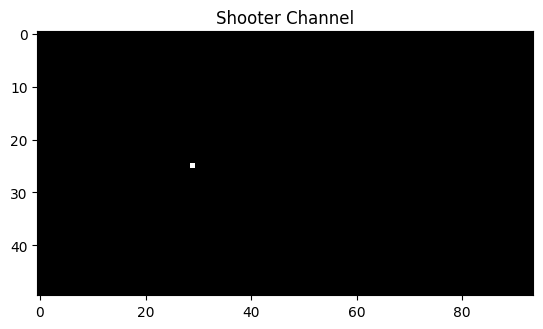

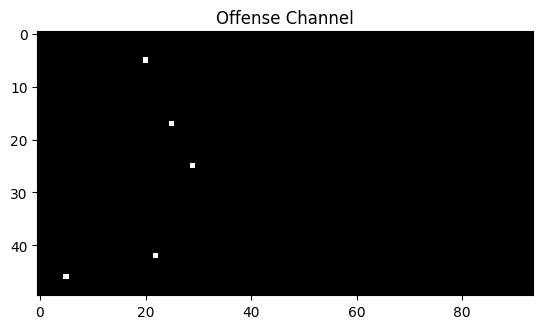

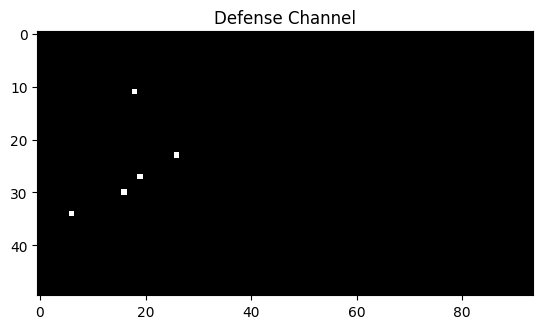

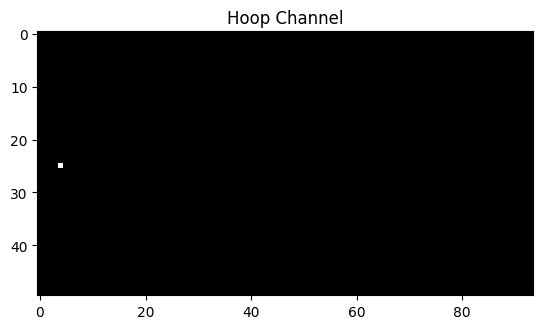

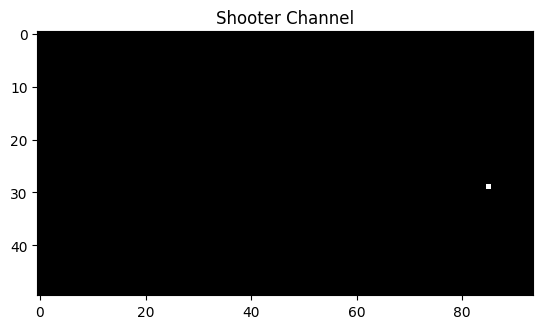

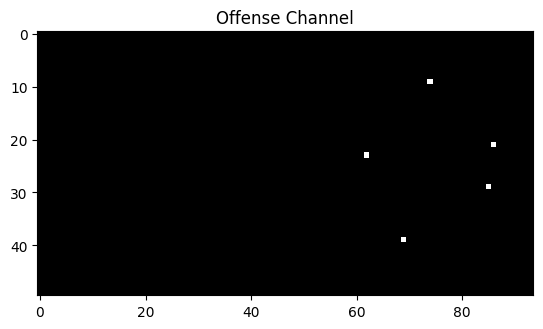

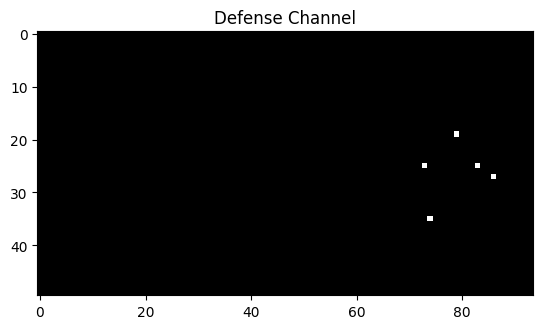

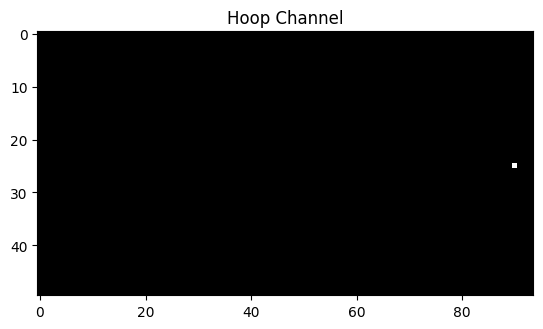

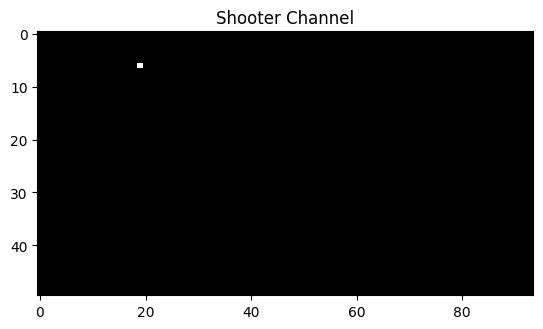

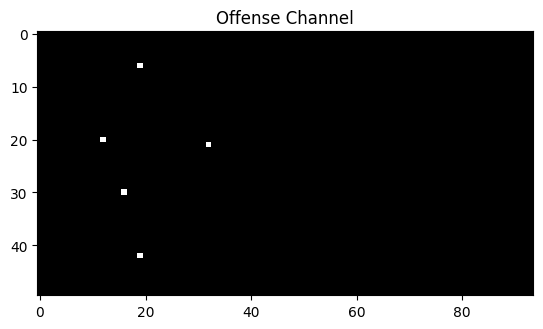

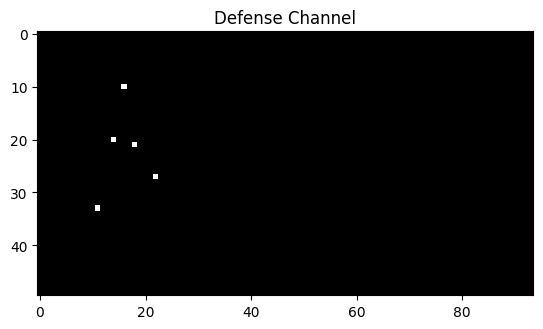

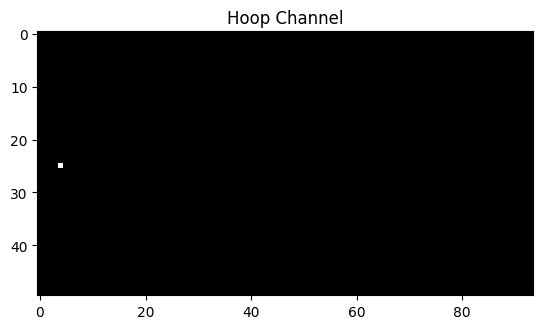

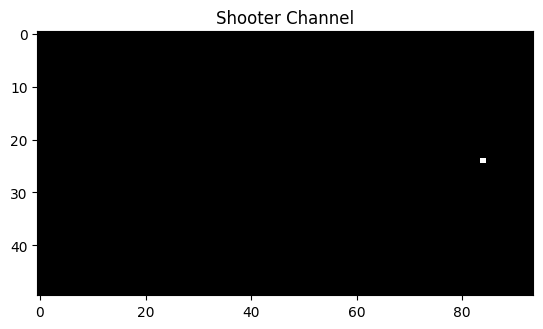

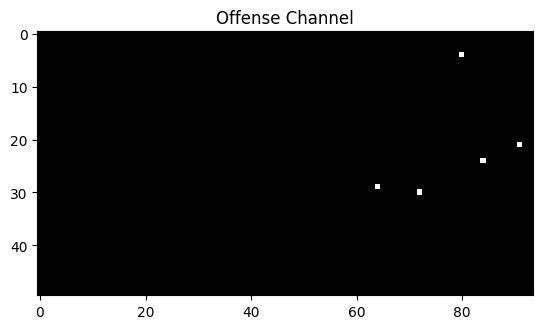

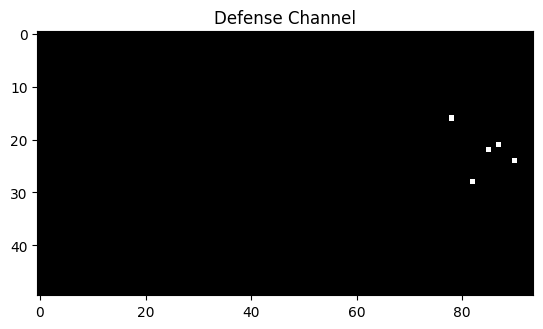

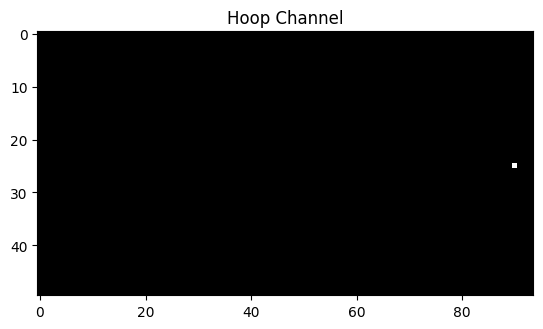

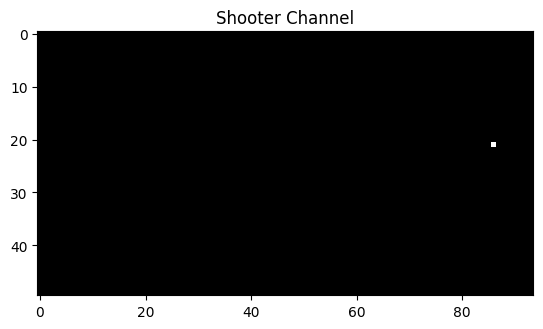

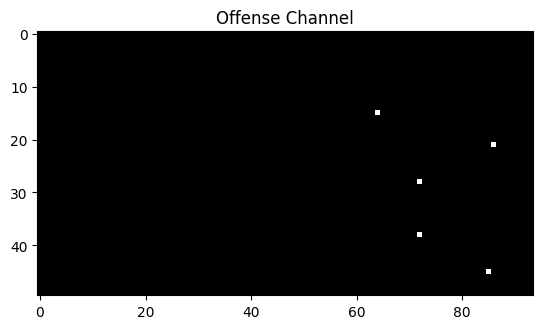

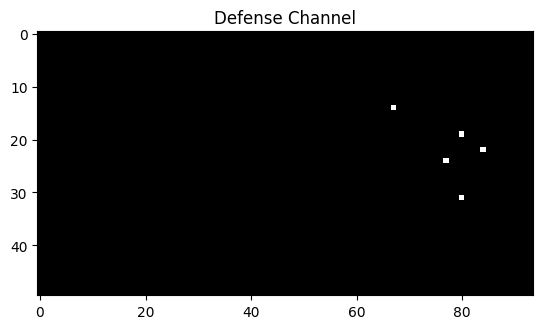

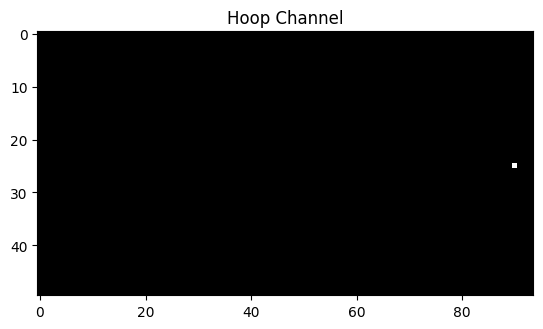

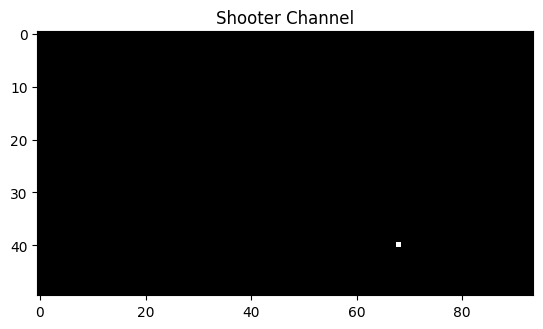

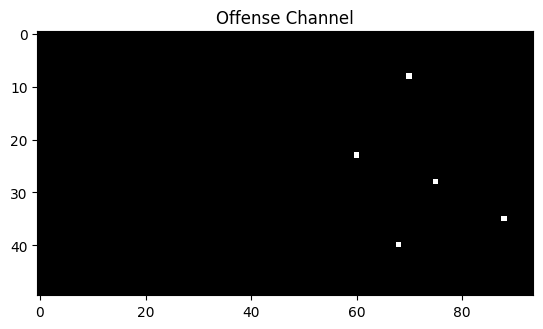

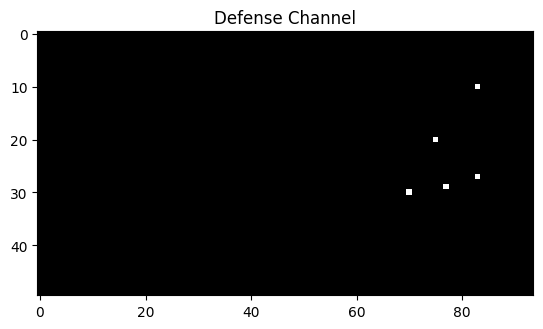

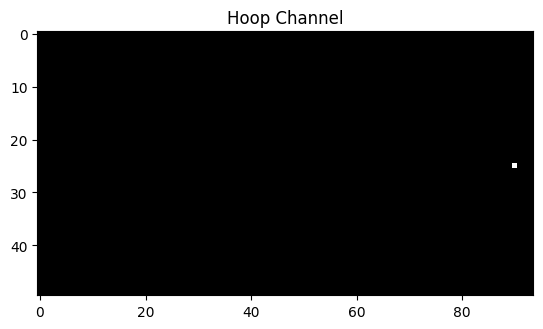

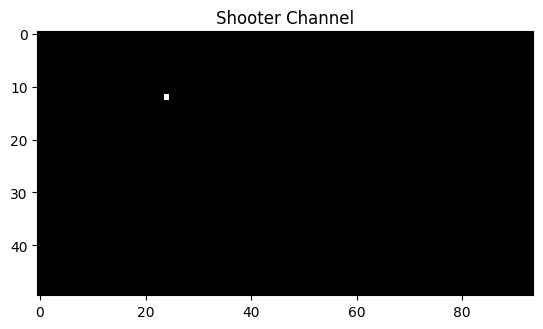

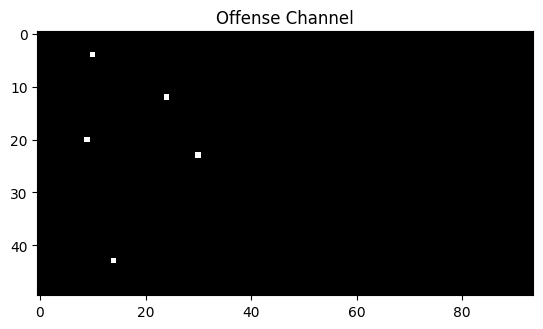

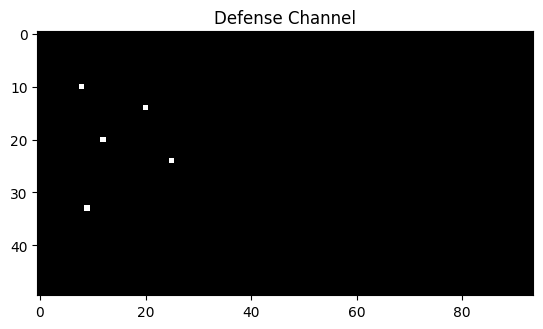

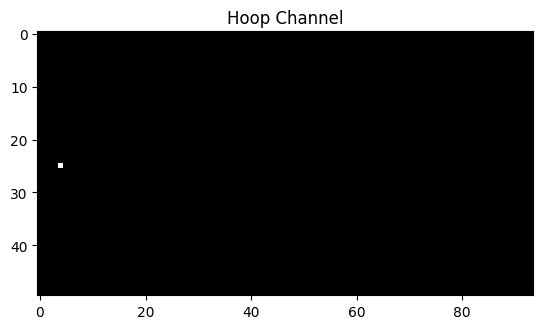

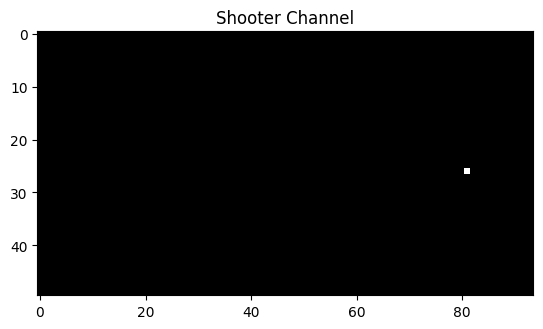

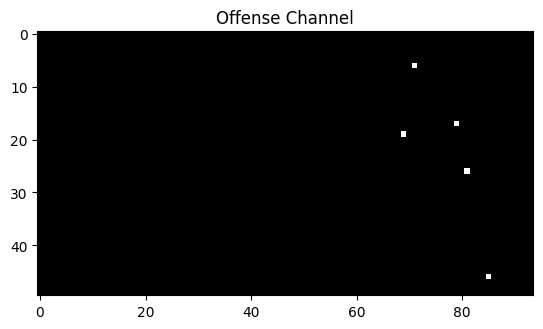

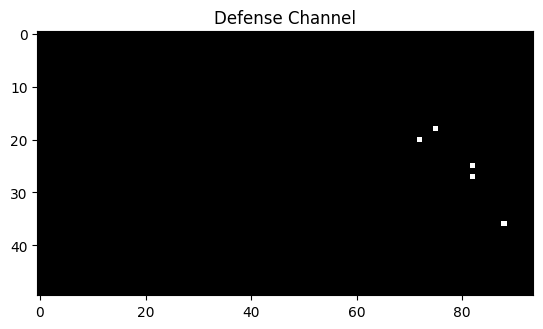

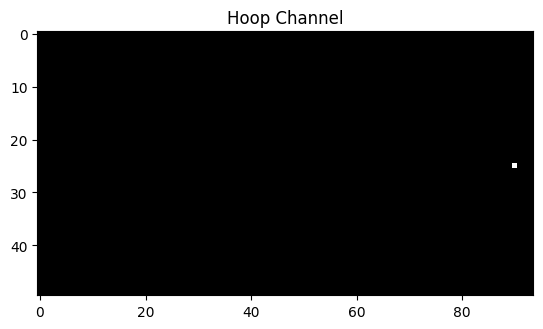

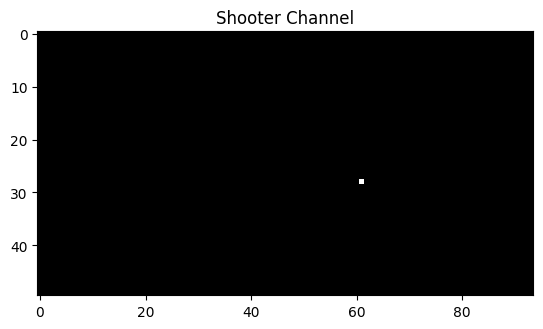

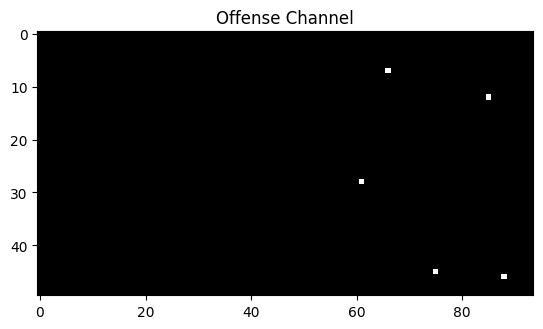

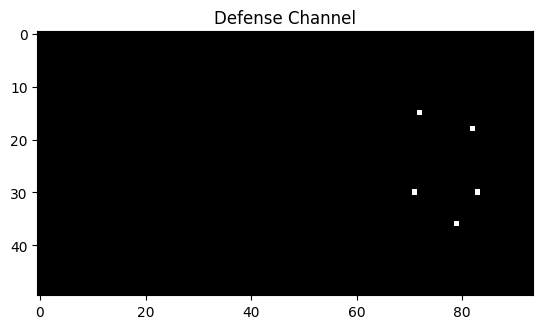

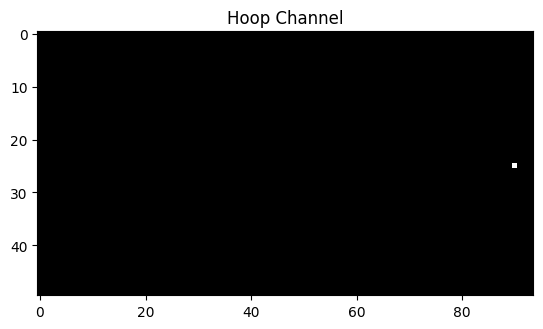

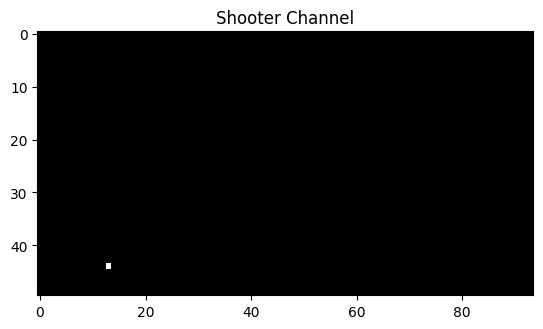

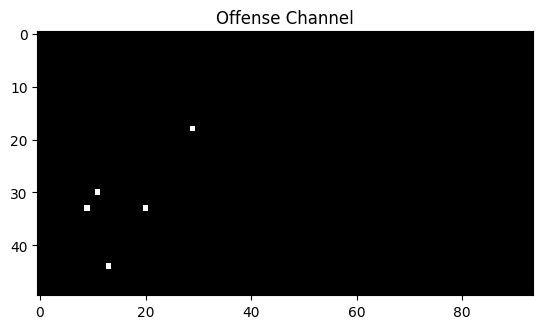

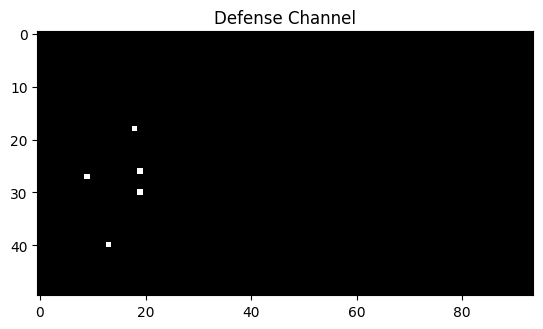

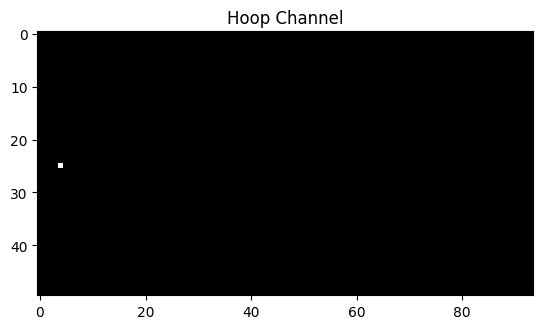

In [139]:
for sample_index in y_train[y_train == 1].index[:10]:
    # Visualize the shooter channel
    plt.imshow(X_test_images[sample_index, :, :, 0], cmap='gray')
    plt.title("Shooter Channel")
    plt.show()

    # Visualize the offense channel
    plt.imshow(X_test_images[sample_index, :, :, 1], cmap='gray')
    plt.title("Offense Channel")
    plt.show()

    # Visualize the defense channel
    plt.imshow(X_test_images[sample_index, :, :, 2], cmap='gray')
    plt.title("Defense Channel")
    plt.show()

    # Visualize the basketball hoop channel
    plt.imshow(X_test_images[sample_index, :, :, 3], cmap='gray')
    plt.title("Hoop Channel")
    plt.show()


In [61]:
y_train = train_pbp['is_oreb']

In [34]:
# Define the file path for saving the data
save_path = 'X_train_images_with_hoop.npz'

# Save the data to the file
np.savez_compressed(save_path, X_train_images=X_train_images)

In [85]:
# Define the file path for saving the data
save_path = 'X_test_images_with_hoop.npz'

# Save the data to the file
np.savez_compressed(save_path, X_test_images=X_test_images)

In [62]:
# Load the data from the file
save_path = 'X_train_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_train_images = loaded_data['X_train_images']

In [63]:
# Load the data from the file
save_path = 'X_test_images_with_hoop.npz'
loaded_data = np.load(save_path)
X_test_images = loaded_data['X_test_images']

Regular CNN

In [18]:
# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train, test_size=0.2, random_state=42)

In [16]:
# # Define the CNN model
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(court_height, court_width, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01)))
# model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# # Compile the model with log loss (binary cross-entropy)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# batch_size = 32
# epochs = 10

# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# # Evaluate the model
# loss, accuracy = model.evaluate(X_val, y_val)
# print(f"Validation Loss (Log Loss): {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


Epoch 1/10
771/771 [==============================] - 172s 221ms/step - loss: 0.6158 - accuracy: 0.7177 - val_loss: 0.6030 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 170s 220ms/step - loss: 0.5956 - accuracy: 0.7182 - val_loss: 0.5974 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 172s 223ms/step - loss: 0.5934 - accuracy: 0.7182 - val_loss: 0.5938 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 169s 220ms/step - loss: 0.5909 - accuracy: 0.7182 - val_loss: 0.5929 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 169s 219ms/step - loss: 0.5898 - accuracy: 0.7182 - val_loss: 0.5914 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 180s 233ms/step - loss: 0.5891 - accuracy: 0.7182 - val_loss: 0.5943 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 180s 234ms/step - loss: 0.5889 - accuracy: 0.7182 - val_loss: 0.5920 -

In [65]:
shooter_data_train['mean_def_dist'] = def_mean_distances_train.values
shooter_data_test['mean_def_dist'] = def_mean_distances_test.values

In [66]:
cnn_train_data = shooter_data_train[['mean_def_dist', 'distance_from_hoop']]
cnn_test_data = shooter_data_test[['mean_def_dist', 'distance_from_hoop']]

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data = scaler.fit_transform(cnn_train_data)
test_data = scaler.transform(cnn_test_data)

In [68]:
normalized_df[['mean_def_dist', 'distance_from_hoop']] = train_data
normalized_df_test[['mean_def_dist', 'distance_from_hoop']] = test_data

In [70]:
normalized_df.head(2)

,id,angle_defender_vertex_1,angle_defender_vertex_2,angle_defender_vertex_3,angle_defender_vertex_4,angle_defender_vertex_5,distance_def_hoop_1,distance_def_hoop_2,distance_def_hoop_3,distance_def_hoop_4,...,distance_def_off_3,distance_def_off_4,distance_def_off_5,distance_off_hoop_1,distance_off_hoop_2,distance_off_hoop_3,distance_off_hoop_4,distance_off_hoop_5,mean_def_dist,distance_from_hoop
0,10-10,-0.507281,-0.190575,-0.447978,-0.427008,-0.875265,-0.125753,0.54100,-0.380263,-0.573869,...,1.480267,-1.464448,-0.231571,-0.304833,0.849623,0.890762,-1.142590,0.196883,-0.140019,0.901058
1,10-12,0.841641,0.171283,0.055200,-0.915704,-0.727249,-1.368283,-1.53575,-0.257683,0.476611,...,0.563381,-0.280688,-0.148141,-1.571777,-0.030186,0.282859,0.428425,0.493668,-0.873384,0.057110


In [71]:
normalized_df_test.drop(columns='id', inplace=True)
normalized_df.drop(columns='id', inplace=True)

In [72]:
# Split the data into training and validation sets
X_train_img, X_val_img, y_tr, y_val = train_test_split(X_train_images, y_train, test_size=0.2, random_state=42)
X_train_, X_val_, _, _ = train_test_split(normalized_df, y_train, test_size=0.2, random_state=42)

In [73]:
# Print the shapes of input data
print("Shape of X_train_img:", X_train_img.shape)
print("Shape of X_train_:", X_train_.shape)
print("Shape of X_val_img:", X_val_img.shape)
print("Shape of X_val_:", X_val_.shape)
print("Shape of y_tr:", y_tr.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train_img: (24644, 50, 94, 4)
Shape of X_train_: (24644, 22)
Shape of X_val_img: (6161, 50, 94, 4)
Shape of X_val_: (6161, 22)
Shape of y_tr: (24644,)
Shape of y_val: (6161,)


Model Architecture:

- CNN Model for Image Data:
    - Input shape: (court_height, court_width, 4) (Assuming 4 channels for the image data)
    - Conv2D Layers: 3 layers with 32, 64, and 128 filters and 'relu' activation
    - MaxPooling2D Layers: Applied after each Conv2D layer with (2, 2) pool size
    - Flatten Layer: Flattens the output of the last MaxPooling2D layer
    - Dense Layer: 256 neurons with 'relu' activation and L2 regularization (lambda = 0.01)
    - Dropout Layer: Dropout rate of 0.5 applied after the Dense layer
- Input Layer for Rebound Percentage Features:
    - Input shape: (2,)
- Concatenation:
    - Concatenates the outputs from the two branches (CNN model and rebound percentage features)
- Output Layer:
    - Dense layer with 1 neuron and 'sigmoid' activation
Model Performance:

Epochs: 10
Batch Size: 32
Training Time: Approximately 10 minutes per epoch
Validation Log Loss: 0.5925
Validation Accuracy: 0.7174

In [126]:
# Define the CNN model for image data
input_img = Input(shape=(court_height, court_width, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(2,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit([X_train_img, X_train_], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_])

val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/10
771/771 [==============================] - 62s 79ms/step - loss: 0.6307 - accuracy: 0.7166 - val_loss: 0.6024 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 64s 83ms/step - loss: 0.5996 - accuracy: 0.7182 - val_loss: 0.5973 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 65s 84ms/step - loss: 0.5964 - accuracy: 0.7182 - val_loss: 0.5977 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 70s 91ms/step - loss: 0.5950 - accuracy: 0.7182 - val_loss: 0.5953 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 76s 98ms/step - loss: 0.5932 - accuracy: 0.7182 - val_loss: 0.5956 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 76s 98ms/step - loss: 0.5927 - accuracy: 0.7182 - val_loss: 0.5937 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 80s 104ms/step - loss: 0.5888 - accuracy: 0.7182 - val_loss: 0.5917 - val_accuracy

In [76]:
# Define the CNN model for image data
input_img = Input(shape=(50, 94, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(22,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 20
history = model.fit([X_train_img, X_train_], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_])

val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/20
771/771 [==============================] - 82s 105ms/step - loss: 0.6338 - accuracy: 0.7120 - val_loss: 0.5998 - val_accuracy: 0.7173
Epoch 2/20
771/771 [==============================] - 82s 106ms/step - loss: 0.5994 - accuracy: 0.7183 - val_loss: 0.5957 - val_accuracy: 0.7174
Epoch 3/20
771/771 [==============================] - 82s 107ms/step - loss: 0.5973 - accuracy: 0.7182 - val_loss: 0.5988 - val_accuracy: 0.7174
Epoch 4/20
771/771 [==============================] - 82s 106ms/step - loss: 0.5995 - accuracy: 0.7181 - val_loss: 0.5950 - val_accuracy: 0.7174
Epoch 5/20
771/771 [==============================] - 80s 104ms/step - loss: 0.5920 - accuracy: 0.7181 - val_loss: 0.5958 - val_accuracy: 0.7174
Epoch 6/20
771/771 [==============================] - 82s 107ms/step - loss: 0.5893 - accuracy: 0.7182 - val_loss: 0.5914 - val_accuracy: 0.7174
Epoch 7/20
771/771 [==============================] - 85s 110ms/step - loss: 0.5873 - accuracy: 0.7182 - val_loss: 0.5948 - val_ac

In [89]:
# Define the CNN model for image data
input_img = Input(shape=(50, 94, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(22,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 20

# Define the EarlyStopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit([X_train_img, X_train_], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_], y_val), callbacks=[early_stopping])

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_])

val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/20
771/771 [==============================] - 78s 100ms/step - loss: 0.6328 - accuracy: 0.7098 - val_loss: 0.6033 - val_accuracy: 0.7174
Epoch 2/20
771/771 [==============================] - 87s 112ms/step - loss: 0.5998 - accuracy: 0.7182 - val_loss: 0.5976 - val_accuracy: 0.7174
Epoch 3/20
771/771 [==============================] - 85s 111ms/step - loss: 0.5978 - accuracy: 0.7182 - val_loss: 0.5959 - val_accuracy: 0.7174
Epoch 4/20
771/771 [==============================] - 90s 117ms/step - loss: 0.5941 - accuracy: 0.7181 - val_loss: 0.5953 - val_accuracy: 0.7174
Epoch 5/20
771/771 [==============================] - 97s 126ms/step - loss: 0.5907 - accuracy: 0.7181 - val_loss: 0.5917 - val_accuracy: 0.7174
Epoch 6/20
771/771 [==============================] - 98s 127ms/step - loss: 0.5889 - accuracy: 0.7182 - val_loss: 0.5926 - val_accuracy: 0.7174
Epoch 7/20
771/771 [==============================] - 88s 115ms/step - loss: 0.5877 - accuracy: 0.7181 - val_loss: 0.5920 - val_ac

In [102]:
val_predictions.max()

0.48776087

In [78]:
# Define the CNN model for image data
input_img = Input(shape=(50, 94, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(22,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 20

# Define the EarlyStopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit([X_train_img, X_train_], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_], y_val), callbacks=[early_stopping])

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_])

val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/20
771/771 [==============================] - 73s 94ms/step - loss: 0.6206 - accuracy: 0.7137 - val_loss: 0.6055 - val_accuracy: 0.7174
Epoch 2/20
771/771 [==============================] - 72s 93ms/step - loss: 0.6028 - accuracy: 0.7182 - val_loss: 0.6009 - val_accuracy: 0.7174
Epoch 3/20
771/771 [==============================] - 72s 94ms/step - loss: 0.6003 - accuracy: 0.7182 - val_loss: 0.5967 - val_accuracy: 0.7174
Epoch 4/20
771/771 [==============================] - 73s 94ms/step - loss: 0.5998 - accuracy: 0.7181 - val_loss: 0.5991 - val_accuracy: 0.7174
Epoch 5/20
771/771 [==============================] - 75s 97ms/step - loss: 0.5992 - accuracy: 0.7179 - val_loss: 0.5995 - val_accuracy: 0.7174
Epoch 6/20
771/771 [==============================] - 73s 95ms/step - loss: 0.5970 - accuracy: 0.7181 - val_loss: 0.5984 - val_accuracy: 0.7174
Epoch 7/20
771/771 [==============================] - 72s 94ms/step - loss: 0.5968 - accuracy: 0.7182 - val_loss: 0.5975 - val_accuracy:

In [87]:
val_predictions.max()

0.37035796

Best model to this point

In [82]:
# Define the CNN model for image data
input_img = Input(shape=(50, 94, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(22,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 8

history = model.fit([X_train_images, normalized_df], y_train_official, batch_size=batch_size, epochs=epochs)

Epoch 1/8
963/963 [==============================] - 102s 105ms/step - loss: 0.6399 - accuracy: 0.7048
Epoch 2/8
963/963 [==============================] - 107s 111ms/step - loss: 0.6005 - accuracy: 0.7180
Epoch 3/8
963/963 [==============================] - 104s 108ms/step - loss: 0.5956 - accuracy: 0.7181
Epoch 4/8
963/963 [==============================] - 104s 108ms/step - loss: 0.5911 - accuracy: 0.7180
Epoch 5/8
963/963 [==============================] - 103s 107ms/step - loss: 0.5892 - accuracy: 0.7180
Epoch 6/8
963/963 [==============================] - 97s 100ms/step - loss: 0.5876 - accuracy: 0.7180
Epoch 7/8
963/963 [==============================] - 74s 77ms/step - loss: 0.5859 - accuracy: 0.7181
Epoch 8/8
963/963 [==============================] - 86s 89ms/step - loss: 0.5857 - accuracy: 0.7181


In [96]:
a = pd.DataFrame(test_predictions)

In [98]:
a

,0
0,0.344994
1,0.186436
2,0.417137
3,0.205829
4,0.335694
...,...
13197,0.276760
13198,0.295792
13199,0.327836
13200,0.203472


In [100]:
a.sort_values(0)[-25:]

,0
3783,0.449864
12872,0.450599
8417,0.450749
2684,0.451042
3212,0.451441
7226,0.452273
6479,0.453029
5302,0.453814
12987,0.455586
8485,0.456140


In [90]:
# Evaluate the model on the validation set
test_predictions = model.predict([X_test_images, np.array(normalized_df_test)])

test_predictions_flattened = test_predictions.flatten()

413/413 [==============================] - 10s 24ms/step


In [109]:
submission = pd.DataFrame(test_pbp['id'])
submission['pred'] = test_predictions_flattened
submission.to_csv('submission1.csv', index=False)

In [105]:
submission.to_csv('submission1.csv')

In [107]:
type(submission)

pandas.core.series.Series

In [615]:
np.array(normalized_df_test)

array([[ 0.54949442, -0.7625908 , -0.87198624, ...,  0.1779102 ,
        -1.29078943, -0.24489594],
       [ 0.11438481, -0.64964036,  0.71797827, ...,  0.56972094,
         0.59563348, -0.06407105],
       [-0.46026631,  1.45554429, -0.17195773, ...,  0.06726891,
         0.58895496, -0.02972417],
       ...,
       [-0.57075973,  0.14293357, -0.57588115, ..., -0.56039028,
         1.06734809, -1.66515497],
       [-0.60552051, -0.40733816,  0.46628003, ...,  1.14282728,
        -0.84674969,  0.25715223],
       [-0.48273556, -0.46506923,  1.24993252, ...,  0.2135837 ,
         0.44560423,  0.66557705]])

In [79]:
y_train_official = train_pbp['is_oreb']

In [125]:
# Define the CNN model for image data
input_img = Input(shape=(court_height, court_width, 4))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu')(x)
# x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

input_rebounds = Input(shape=(2,)) 

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit([X_train_img, X_train_], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_])

val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/10
771/771 [==============================] - 60s 76ms/step - loss: 0.6303 - accuracy: 0.7171 - val_loss: 0.6130 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 56s 73ms/step - loss: 0.6054 - accuracy: 0.7182 - val_loss: 0.6011 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 57s 74ms/step - loss: 0.5988 - accuracy: 0.7182 - val_loss: 0.5962 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 58s 75ms/step - loss: 0.5953 - accuracy: 0.7182 - val_loss: 0.5990 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 63s 81ms/step - loss: 0.5935 - accuracy: 0.7182 - val_loss: 0.5922 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 61s 79ms/step - loss: 0.5936 - accuracy: 0.7182 - val_loss: 0.5963 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 62s 81ms/step - loss: 0.5934 - accuracy: 0.7182 - val_loss: 0.5931 - val_accuracy:

In [116]:
X_train_img.shape, X_train_.shape

((24644, 50, 94, 4), (24644, 2))

In [134]:
# Define the CNN model as a function
def create_model(learning_rate=0.001, dropout_rate=0.5, dense_units=128, include_last_conv_layer=True):
    input_img = Input(shape=(court_height, court_width, 4))
    x = Conv2D(32, (3, 3), activation='relu')(input_img)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    if include_last_conv_layer:
        x = Conv2D(128, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)

    
    model = Model(inputs=[input_img], outputs=output)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create KerasClassifier wrapper for scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameter grid for the randomized search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'dense_units': [64, 128, 256],
    'include_last_conv_layer': [True, False]
}

# Define log loss as the scoring metric
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_grid, scoring=log_loss_scorer, n_iter=5, cv=3, verbose=3)

random_search_results = random_search.fit(X_train_img, y_tr)

# Print the best hyperparameters and log loss score
print("Best Hyperparameters:", random_search_results.best_params_)
print("Best Log Loss:", -random_search_results.best_score_)


C:\Users\timse\AppData\Local\Temp\ipykernel_20052\3079426148.py:32: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
257/257 [==============================] - 6s 22ms/step
[CV 1/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.591 total time=  49.5s
257/257 [==============================] - 6s 22ms/step
[CV 2/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.596 total time=  53.2s
257/257 [==============================] - 6s 24ms/step
[CV 3/3] END dense_units=128, dropout_rate=0.5, include_last_conv_layer=True, learning_rate=0.1;, score=-0.598 total time=  52.8s
257/257 [==============================] - 6s 23ms/step
[CV 1/3] END dense_units=256, dropout_rate=0.4, include_last_conv_layer=False, learning_rate=0.1;, score=-0.592 total time=  56.8s
257/257 [==============================] - 5s 20ms/step
[CV 2/3] END dense_units=256, dropout_rate=0.4, include_last_conv_layer=False, learning_rate=0.1;, score=-0.596 total time=  55.5s
257/257 

In [109]:
conf_matrix = confusion_matrix(y_val, (val_predictions.flatten() > 0.5))

In [110]:
conf_matrix

array([[4420,    0],
       [1741,    0]], dtype=int64)

In [111]:
val_predictions

array([[0.20548178],
       [0.2878199 ],
       [0.23514229],
       ...,
       [0.35730284],
       [0.3443506 ],
       [0.26466092]], dtype=float32)

In [167]:
# Define the CNN model for image data
input_img = Input(shape=(court_height, court_width, 3))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

# Define the input layer for rebound percentage features
input_rebounds = Input(shape=(2,))  # Assuming 1 feature for rebound percentages

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit([X_train_img, X_train_rebounds], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_rebounds], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_rebounds])
val_loss = log_loss(y_val, val_predictions)
val_accuracy = np.mean((val_predictions > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/10
771/771 [==============================] - 70s 89ms/step - loss: 0.6724 - accuracy: 0.7176 - val_loss: 0.6003 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 71s 92ms/step - loss: 0.5996 - accuracy: 0.7182 - val_loss: 0.5989 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 69s 90ms/step - loss: 0.5979 - accuracy: 0.7182 - val_loss: 0.5951 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 68s 89ms/step - loss: 0.5936 - accuracy: 0.7182 - val_loss: 0.5938 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 74s 96ms/step - loss: 0.5904 - accuracy: 0.7182 - val_loss: 0.5881 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 73s 94ms/step - loss: 0.5873 - accuracy: 0.7182 - val_loss: 0.5879 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 75s 98ms/step - loss: 0.5854 - accuracy: 0.7182 - val_loss: 0.5860 - val_accuracy:

C:\Users\timse\AppData\Local\Temp\ipykernel_16216\2900417551.py:34: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



ValueError: Data must be 1-dimensional

In [1]:
val_predictions.flatten()

NameError: name 'val_predictions' is not defined

In [168]:
val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Log Loss: 0.5820042970390139
Validation Accuracy: 0.7175783152085701


In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
train_pbp['team'].value_counts()

Duke                 1432
Kentucky              963
Alabama               758
Auburn                757
Arizona               750
                     ... 
Bradley                 9
Texas Southern          9
Belmont                 9
Southern Illinois       9
Utah Valley             6
Name: team, Length: 160, dtype: int64

Thoughts:
- tendencies to get back on defense may determine how often there is an offensive rebound - past offensive rebounding performance by team may be helpful
- spacing
- strength of the team / athleticisim of the players may be informed by conference

In [ ]:
training_data

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC
...,...,...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,0,San Diego St.,Connecticut,MWC,BigEast
308046,5020-52,86.958520,4.382292,t1,0,San Diego St.,Connecticut,MWC,BigEast
308047,5020-52,58.962087,26.764930,t2,0,San Diego St.,Connecticut,MWC,BigEast
308048,5020-52,76.777949,20.427222,t3,0,San Diego St.,Connecticut,MWC,BigEast


In [ ]:
X_train = training_data[['court_x', 'court_y', 'annotation_code']]
X_test = testing_data[['court_x', 'court_y', 'annotation_code']]
y_train = training_data['is_oreb']
y_test = training_data['is_oreb']

In [ ]:
X_train.drop(columns='annotation_code', inplace=True)
X_test.drop(columns='annotation_code', inplace=True)

<ipython-input-21-4b650e9c37e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns='annotation_code', inplace=True)
<ipython-input-21-4b650e9c37e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns='annotation_code', inplace=True)


There are imperfect maximums and minimums in the training set, so to ensure the actual player positions are not distorted, I will make a custom scaler instead of using minmax scaler

In [ ]:
X_train.max(), X_train.min()

(court_x    93.92656
 court_y    50.00000
 offense     1.00000
 shooter     1.00000
 dtype: float64,
 court_x    0.004518
 court_y    0.980564
 offense    0.000000
 shooter    0.000000
 dtype: float64)

In [ ]:
pd.read_csv('sample_sumbission.csv')

,id,pred
0,10-36,0.055351
1,264-34,0.101707
2,97-55,0.133729
3,299-28,0.494946
4,127-25,0.522130
5,188-58,0.782107
6,145-9,0.084935
7,72-5,0.186027
8,95-33,0.914862
9,286-69,0.662853


In [ ]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
308045    0
308046    0
308047    0
308048    0
308049    0
Name: is_oreb, Length: 308050, dtype: int64

In [ ]:
# Assuming you have the feature-engineered X_train and X_test DataFrames
x_max_val = 94  # Maximum value for x coordinate
x_min_val = 0   # Minimum value for x coordinate
y_max_val = 50  # Maximum value for y coordinate
y_min_val = 0   # Minimum value for y coordinate

# Separate features and labels in X_train and X_test
X_train_features = X_train.drop(columns=['offense', 'shooter'])  # Excluding 'offense' and 'shooter' columns
X_test_features = X_test.drop(columns=['offense', 'shooter'])    # Excluding 'offense' and 'shooter' columns
y_train_labels = X_train[['offense', 'shooter']]  # 'offense' and 'shooter' columns as labels for y_train
y_test_labels = X_test[['offense', 'shooter']]    # 'offense' and 'shooter' columns as labels for y_test

# Custom normalization function
def custom_normalize(data, max_val, min_val):
    return (data - min_val) / (max_val - min_val)

# Apply custom normalization to features
X_train_normalized = X_train_features.copy()
X_train_normalized['court_x'] = custom_normalize(X_train_features['court_x'], x_max_val, x_min_val)
X_train_normalized['court_y'] = custom_normalize(X_train_features['court_y'], y_max_val, y_min_val)

X_test_normalized = X_test_features.copy()
X_test_normalized['court_x'] = custom_normalize(X_test_features['court_x'], x_max_val, x_min_val)
X_test_normalized['court_y'] = custom_normalize(X_test_features['court_y'], y_max_val, y_min_val)

# Add the labels back to the preprocessed DataFrames
X_train_normalized[['offense', 'shooter']] = y_train_labels.reset_index(drop=True)
X_test_normalized[['offense', 'shooter']] = y_test_labels.reset_index(drop=True)

# Now, X_train_normalized contains the normalized data for X_train with labels,
# and X_test_normalized contains the normalized data for X_test with labels.
